# Gemma2-27B Weight Diff & PC Vector Analysis

This notebook:
1. Loads Gemma2-27B base and instruct models in bf16 on CPU
2. Computes weight differences between the models
3. Loads PC vectors from persona subspace data
4. **Applies appropriate layernorms** (input_layernorm for attention, pre_feedforward_layernorm for MLP)
5. Analyzes whether PC1 activates downstream neurons in the weight diff more than other PCs

**Key insight**: PC vectors must be passed through layernorm before projecting through downstream weight matrices, matching the actual forward pass architecture.

In [28]:
import torch
import numpy as np
from transformers import AutoModelForCausalLM
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.8.0+cu128
CUDA available: True


## 1. Load Gemma2-27B Models

In [29]:
# Model identifiers
base_model_id = "google/gemma-2-27b"
instruct_model_id = "google/gemma-2-27b-it"

print("Loading base model...")
base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,
    torch_dtype=torch.bfloat16,
    device_map="cpu",
    low_cpu_mem_usage=True
).eval().requires_grad_(False)

print("Loading instruct model...")
instruct_model = AutoModelForCausalLM.from_pretrained(
    instruct_model_id,
    torch_dtype=torch.bfloat16,
    device_map="cpu",
    low_cpu_mem_usage=True
).eval().requires_grad_(False)

print("\nModels loaded successfully!")
print(f"Base model device: {next(base_model.parameters()).device}")
print(f"Instruct model device: {next(instruct_model.parameters()).device}")

Loading base model...


Loading checkpoint shards:   0%|          | 0/24 [00:00<?, ?it/s]

Loading instruct model...


Loading checkpoint shards:   0%|          | 0/12 [00:00<?, ?it/s]


Models loaded successfully!
Base model device: cpu
Instruct model device: cpu


## 2. Compute Weight Differences

In [30]:
# Get parameter names and compute differences
weight_diffs = {}

base_state_dict = base_model.state_dict()
instruct_state_dict = instruct_model.state_dict()

print("Computing weight differences...")
for name in tqdm(base_state_dict.keys()):
    if name in instruct_state_dict:
        base_param = base_state_dict[name]
        instruct_param = instruct_state_dict[name]
        
        # Compute difference
        diff = instruct_param - base_param
        weight_diffs[name] = diff
        
print(f"\nComputed differences for {len(weight_diffs)} parameters")

# Show some statistics
print("\nSample of weight differences:")
for i, (name, diff) in enumerate(list(weight_diffs.items())[:5]):
    print(f"  {name}: shape={diff.shape}, mean={diff.float().mean().item():.6e}, std={diff.float().std().item():.6e}")

Computing weight differences...


  0%|          | 0/509 [00:00<?, ?it/s]


Computed differences for 509 parameters

Sample of weight differences:
  model.embed_tokens.weight: shape=torch.Size([256000, 4608]), mean=1.028630e-05, std=9.579425e-04
  model.layers.0.self_attn.q_proj.weight: shape=torch.Size([4096, 4608]), mean=-1.288689e-06, std=4.283553e-03
  model.layers.0.self_attn.k_proj.weight: shape=torch.Size([2048, 4608]), mean=7.221636e-07, std=1.688936e-03
  model.layers.0.self_attn.v_proj.weight: shape=torch.Size([2048, 4608]), mean=1.968820e-07, std=1.676724e-03
  model.layers.0.self_attn.o_proj.weight: shape=torch.Size([4608, 4096]), mean=3.286279e-07, std=6.704608e-04


In [31]:
# Get model architecture info
config = base_model.config
print(f"Model config:")
print(f"  Hidden size: {config.hidden_size}")
print(f"  Num layers: {config.num_hidden_layers}")
print(f"  Intermediate size: {config.intermediate_size}")
print(f"  Num attention heads: {config.num_attention_heads}")

Model config:
  Hidden size: 4608
  Num layers: 46
  Intermediate size: 36864
  Num attention heads: 32


## 3. Load PC Vectors from Persona Subspace Data

In [32]:
# Path to persona subspace data
persona_data_root = Path("/root/chatspace/persona-data")

# Let's check what's available
if persona_data_root.exists():
    print("Persona data directory exists")
    print("\nAvailable models:")
    for model_dir in persona_data_root.iterdir():
        if model_dir.is_dir():
            print(f"  {model_dir.name}")
else:
    print(f"Warning: {persona_data_root} does not exist")
    print("Looking in /workspace for persona data...")
    workspace_persona = Path("/workspace/persona-data")
    if workspace_persona.exists():
        persona_data_root = workspace_persona
        print(f"Found persona data at {persona_data_root}")

Looking in /workspace for persona data...
Found persona data at /workspace/persona-data


In [33]:
# Load PCA data for gemma-2-27b
# Try both roles and traits
gemma_model_name = "gemma-2-27b"  # or whatever the directory is called

# Look for PCA files
roles_pca_dir = persona_data_root / gemma_model_name / "roles_240" / "pca"
traits_pca_dir = persona_data_root / gemma_model_name / "traits_240" / "pca"

print(f"Checking for PCA data...")
print(f"  Roles PCA dir exists: {roles_pca_dir.exists()}")
print(f"  Traits PCA dir exists: {traits_pca_dir.exists()}")

if roles_pca_dir.exists():
    print(f"\nRoles PCA files:")
    for f in sorted(roles_pca_dir.glob("*.pt")):
        print(f"  {f.name}")
        
if traits_pca_dir.exists():
    print(f"\nTraits PCA files:")
    for f in sorted(traits_pca_dir.glob("*.pt")):
        print(f"  {f.name}")

Checking for PCA data...
  Roles PCA dir exists: True
  Traits PCA dir exists: True

Roles PCA files:
  layer22_pos23.pt
  layer22_pos3.pt
  layer34_pos23.pt
  layer34_pos3.pt

Traits PCA files:
  layer20_pos-neg50_torch.pt
  layer22_pos-neg50.pt
  layer22_pos-neg50_torch.pt
  layer34_pos-neg50.pt


In [34]:
# Load a specific PCA file
# Let's start with roles - pick a layer (e.g., middle layer)
# We'll need to figure out which layer file exists first

def load_pca_data(pca_dir, pattern="*.pt"):
    """Load PCA data from a directory."""
    pca_files = sorted(pca_dir.glob(pattern))
    if not pca_files:
        raise FileNotFoundError(f"No PCA files found matching {pattern} in {pca_dir}")
    
    # Load first file as example
    pca_file = pca_files[0]
    print(f"Loading {pca_file.name}...")
    # Note: weights_only=False is needed because PCA files contain sklearn objects
    pca_data = torch.load(pca_file, map_location='cpu', weights_only=False)
    
    print(f"\nPCA data keys: {list(pca_data.keys())}")
    print(f"Layer: {pca_data.get('layer', 'unknown')}")
    print(f"Number of components: {pca_data.get('n_components', 'unknown')}")
    print(f"Variance explained shape: {pca_data.get('variance_explained', np.array([])).shape}")
    
    return pca_data, pca_files

# Try loading roles PCA data
if roles_pca_dir.exists():
    pca_data, all_pca_files = load_pca_data(roles_pca_dir)
    print(f"\nTotal PCA files available: {len(all_pca_files)}")

Loading layer22_pos23.pt...



PCA data keys: ['layer', 'roles', 'vectors', 'pca_transformed', 'variance_explained', 'n_components', 'pca', 'scaler']
Layer: 22
Number of components: 448
Variance explained shape: (448,)

Total PCA files available: 4


/root/chatspace/.venv/lib/python3.11/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.7.0 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/root/chatspace/.venv/lib/python3.11/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.7.0 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [35]:
# Extract PC components from the PCA object
pca = pca_data['pca']
scaler = pca_data['scaler']

# The PC components are stored in pca.components_
# Shape: (n_components, n_features)
pc_components = pca.components_
print(f"PC components shape: {pc_components.shape}")
print(f"This means {pc_components.shape[0]} PCs, each of dimension {pc_components.shape[1]}")

# Get individual PCs
pc1 = torch.tensor(pc_components[0], dtype=torch.bfloat16)
pc2 = torch.tensor(pc_components[1], dtype=torch.bfloat16) if pc_components.shape[0] > 1 else None
pc3 = torch.tensor(pc_components[2], dtype=torch.bfloat16) if pc_components.shape[0] > 2 else None

print(f"\nPC1 shape: {pc1.shape}")
print(f"PC1 norm: {pc1.float().norm().item():.4f}")

# Show variance explained
variance_explained = pca_data['variance_explained']
print(f"\nVariance explained by first 5 PCs:")
for i, var in enumerate(variance_explained[:5]):
    print(f"  PC{i+1}: {var:.4f} ({var*100:.2f}%)")

# Interpret PC1 direction by checking role projections
print("\n" + "="*60)
print("INTERPRETING PC1 DIRECTION")
print("="*60)

# Get the role vectors and labels from PCA data
if 'vectors' in pca_data and 'roles' in pca_data:
    role_vectors = pca_data['vectors']
    role_labels = pca_data['roles']
    pca_layer = pca_data['layer']
    
    print(f"PCA layer: {pca_layer}")
    
    # Project role vectors onto PC1
    pc1_projections = {}
    for role_type in role_vectors.keys():
        vectors = role_vectors[role_type]  # list of tensors
        labels = role_labels[role_type]  # list of strings
        
        for vec, label in zip(vectors, labels):
            # vec is shape (n_layers, hidden_dim), we need layer pca_layer
            if vec.dim() == 2:
                vec_at_layer = vec[pca_layer]
            else:
                vec_at_layer = vec
            
            # Project onto PC1: dot product
            projection = (vec_at_layer.float() @ pc1.float()).item()
            pc1_projections[label] = projection
    
    # Sort by projection
    sorted_projections = sorted(pc1_projections.items(), key=lambda x: x[1], reverse=True)
    
    print(f"\nRoles with HIGHEST POSITIVE PC1 projections (+PC1 direction):")
    for role, proj in sorted_projections[:10]:
        print(f"  {proj:+.3f}: {role}")
    
    print(f"\nRoles with HIGHEST NEGATIVE PC1 projections (-PC1 direction):")
    for role, proj in sorted_projections[-10:]:
        print(f"  {proj:+.3f}: {role}")
    
    print("\n" + "="*60)
    print(f"PC1 interpretation: +PC1 = {sorted_projections[0][0]} ... -PC1 = {sorted_projections[-1][0]}")
    print("="*60)
else:
    print("\nWarning: Could not find role vectors in PCA data")

PC components shape: (448, 4608)
This means 448 PCs, each of dimension 4608

PC1 shape: torch.Size([4608])
PC1 norm: 0.9999

Variance explained by first 5 PCs:
  PC1: 0.2122 (21.22%)
  PC2: 0.0820 (8.20%)
  PC3: 0.0682 (6.82%)
  PC4: 0.0522 (5.22%)
  PC5: 0.0458 (4.58%)

INTERPRETING PC1 DIRECTION
PCA layer: 22

Roles with HIGHEST POSITIVE PC1 projections (+PC1 direction):
  +201.947: caveman
  +154.552: eldritch
  +153.774: leviathan
  +101.385: void
  +94.231: aberration
  +93.312: zealot
  +75.332: wraith
  +74.779: tree
  +60.634: fool
  +54.915: whale

Roles with HIGHEST NEGATIVE PC1 projections (-PC1 direction):
  -725.798: planner
  -728.036: researcher
  -729.400: reviewer
  -730.238: evaluator
  -733.189: editor
  -739.627: examiner
  -749.322: validator
  -759.353: proofreader
  -762.419: grader
  -765.779: screener

PC1 interpretation: +PC1 = caveman ... -PC1 = screener


## 4. Implement Gemma2 RMSNorm

Before analyzing PC activations through weight matrices, we need to implement Gemma2's RMSNorm.

**Why this matters:** In Gemma2's architecture, hidden states pass through layernorm before being projected:
- Attention projections (q/k/v_proj) use `input_layernorm`
- MLP projections (gate/up_proj) use `pre_feedforward_layernorm`

Without applying these layernorms, we would be analyzing the wrong activation patterns.

In [36]:
# Implement Gemma2's RMSNorm
def gemma2_rmsnorm(x, weight, eps=1e-6):
    """
    Apply Gemma2's RMSNorm following HuggingFace implementation.
    
    Key difference: Gemma2 does output * (1.0 + weight) instead of output * weight
    
    Args:
        x: input tensor of shape (..., hidden_dim)
        weight: norm weight of shape (hidden_dim,) - initialized as zeros in Gemma2
        eps: epsilon for numerical stability
    
    Returns:
        normalized tensor of same shape as x
    """
    # Convert to float32 for numerical stability
    x_float = x.float()
    weight_float = weight.float()
    
    # Compute RMS norm
    output = x_float * torch.rsqrt(x_float.pow(2).mean(-1, keepdim=True) + eps)
    
    # Gemma2-specific: multiply by (1.0 + weight)
    # See https://github.com/huggingface/transformers/pull/29402
    output = output * (1.0 + weight_float)
    
    return output.to(x.dtype)

print("Gemma2 RMSNorm implementation ready")
print(f"RMS norm epsilon from config: {config.rms_norm_eps}")

Gemma2 RMSNorm implementation ready
RMS norm epsilon from config: 1e-06


## 5. Extract Downstream Weights and LayerNorms

We'll extract:
1. Projection weights from downstream layers (q/k/v_proj for attention, gate/up_proj for MLP)
2. Corresponding layernorm weights (input_layernorm for attention, pre_feedforward_layernorm for MLP)

In [37]:
# Get the layer corresponding to the PCA data
pca_layer = pca_data['layer']
print(f"PCA data is from layer {pca_layer}")

# Find weight matrices that are relevant
# We want weights from NEARBY layers (both before and after pca_layer)
# Specifically: up_proj, gate_proj (MLP) and q_proj, k_proj, v_proj (attention)

relevant_weights = {}
target_weight_types = ['up_proj.weight', 'gate_proj.weight', 'q_proj.weight', 'k_proj.weight', 'v_proj.weight']

# Look at N layers before and after the PCA layer
n_layers_context = 5  # Extended to ±5 layers
upstream_layers = range(max(0, pca_layer - n_layers_context), pca_layer)
downstream_layers = range(pca_layer + 1, min(pca_layer + n_layers_context + 1, config.num_hidden_layers))
all_layers = list(upstream_layers) + list(downstream_layers)

print(f"\nLooking for weights in nearby layers (±{n_layers_context}):")
print(f"  Upstream (before layer {pca_layer}): {list(upstream_layers)}")
print(f"  Downstream (after layer {pca_layer}): {list(downstream_layers)}")

for name, diff in weight_diffs.items():
    # Check if this is a layer we care about
    for layer_num in all_layers:
        layer_prefix = f"model.layers.{layer_num}."
        if name.startswith(layer_prefix):
            # Check if it's one of the weight types we want
            for weight_type in target_weight_types:
                if name.endswith(weight_type):
                    # Determine if upstream or downstream
                    position = "upstream" if layer_num < pca_layer else "downstream"
                    distance = abs(layer_num - pca_layer)
                    print(f"  {name}: {diff.shape} ({position}, distance={distance})")
                    relevant_weights[name] = diff
                    break

print(f"\nFound {len(relevant_weights)} relevant weight matrices")

# Also extract layernorm weights for each nearby layer
# We need both input_layernorm (for attention) and pre_feedforward_layernorm (for MLP)
print(f"\nExtracting layernorm weights for nearby layers...")
layernorm_weights = {}
for layer_num in all_layers:
    input_ln_name = f"model.layers.{layer_num}.input_layernorm.weight"
    pre_ffn_ln_name = f"model.layers.{layer_num}.pre_feedforward_layernorm.weight"
    
    if input_ln_name in base_state_dict:
        layernorm_weights[f"{layer_num}.input_layernorm"] = {
            'base': base_state_dict[input_ln_name],
            'instruct': instruct_state_dict[input_ln_name]
        }
        position = "upstream" if layer_num < pca_layer else "downstream"
        print(f"  Layer {layer_num} input_layernorm ({position}): {base_state_dict[input_ln_name].shape}")
    
    if pre_ffn_ln_name in base_state_dict:
        layernorm_weights[f"{layer_num}.pre_feedforward_layernorm"] = {
            'base': base_state_dict[pre_ffn_ln_name],
            'instruct': instruct_state_dict[pre_ffn_ln_name]
        }
        position = "upstream" if layer_num < pca_layer else "downstream"
        print(f"  Layer {layer_num} pre_feedforward_layernorm ({position}): {base_state_dict[pre_ffn_ln_name].shape}")

PCA data is from layer 22



Looking for weights in nearby layers (±5):
  Upstream (before layer 22): [17, 18, 19, 20, 21]
  Downstream (after layer 22): [23, 24, 25, 26, 27]
  model.layers.17.self_attn.q_proj.weight: torch.Size([4096, 4608]) (upstream, distance=5)
  model.layers.17.self_attn.k_proj.weight: torch.Size([2048, 4608]) (upstream, distance=5)
  model.layers.17.self_attn.v_proj.weight: torch.Size([2048, 4608]) (upstream, distance=5)
  model.layers.17.mlp.gate_proj.weight: torch.Size([36864, 4608]) (upstream, distance=5)
  model.layers.17.mlp.up_proj.weight: torch.Size([36864, 4608]) (upstream, distance=5)
  model.layers.18.self_attn.q_proj.weight: torch.Size([4096, 4608]) (upstream, distance=4)
  model.layers.18.self_attn.k_proj.weight: torch.Size([2048, 4608]) (upstream, distance=4)
  model.layers.18.self_attn.v_proj.weight: torch.Size([2048, 4608]) (upstream, distance=4)
  model.layers.18.mlp.gate_proj.weight: torch.Size([36864, 4608]) (upstream, distance=4)
  model.layers.18.mlp.up_proj.weight: torc

In [38]:
# Function to compute cosine distance for a batch of vectors WITH layernorm
def compute_cosine_distances_batch(vectors, weight_base, weight_instruct, 
                                   ln_weight_base, ln_weight_instruct, eps=1e-6):
    """
    Compute cosine distances for a batch of vectors.
    Applies layernorm before projection.
    
    Args:
        vectors: tensor of shape (n_vectors, hidden_dim)
        weight_base: base model weights
        weight_instruct: instruct model weights
        ln_weight_base: base model layernorm weight
        ln_weight_instruct: instruct model layernorm weight
        eps: epsilon for RMSNorm
    
    Returns:
        list of cosine distances
    """
    if weight_base.dim() == 1:
        return None
    
    if weight_base.shape[1] != vectors.shape[1]:
        return None
    
    # Apply layernorm to all vectors in batch
    vectors_normed_base = gemma2_rmsnorm(vectors, ln_weight_base, eps=eps)
    vectors_normed_instruct = gemma2_rmsnorm(vectors, ln_weight_instruct, eps=eps)
    
    # Batch compute activations
    base_acts = weight_base.float() @ vectors_normed_base.T.float()  # (out_features, n_vectors)
    instruct_acts = weight_instruct.float() @ vectors_normed_instruct.T.float()  # (out_features, n_vectors)
    
    # Compute norms for each vector
    base_norms = base_acts.norm(dim=0)  # (n_vectors,)
    instruct_norms = instruct_acts.norm(dim=0)  # (n_vectors,)
    
    # Compute cosine similarities
    dot_products = (base_acts * instruct_acts).sum(dim=0)  # (n_vectors,)
    cosine_sims = dot_products / (base_norms * instruct_norms + 1e-8)
    
    # Compute cosine distances
    cosine_dists = 1.0 - cosine_sims
    
    return cosine_dists.cpu().numpy()

# Test on all relevant weights
results = {}

# Number of random vectors to average over
n_random_baseline = 20
print(f"Computing input projection analysis with {n_random_baseline} random vectors for baseline")
print(f"Analyzing {len(relevant_weights)} weight matrices across {len(all_layers)} layers\n")

for weight_name in tqdm(relevant_weights.keys(), desc="Processing weights"):
    weight_diff = relevant_weights[weight_name]
    
    # Get corresponding base and instruct weights
    weight_base = base_state_dict[weight_name]
    weight_instruct = instruct_state_dict[weight_name]
    
    if weight_diff.dim() < 2:
        continue
    
    # Determine which layernorm to use based on weight type
    parts = weight_name.split('.')
    layer_num = int(parts[2])  # model.layers.{layer_num}
    weight_type = parts[-2]  # e.g., up_proj, gate_proj, q_proj, k_proj, v_proj
    
    # Select appropriate layernorm
    if weight_type in ['gate_proj', 'up_proj']:
        # MLP weights use pre_feedforward_layernorm
        ln_key = f"{layer_num}.pre_feedforward_layernorm"
    else:
        # Attention weights use input_layernorm
        ln_key = f"{layer_num}.input_layernorm"
    
    if ln_key not in layernorm_weights:
        continue
    
    ln_weight_base = layernorm_weights[ln_key]['base']
    ln_weight_instruct = layernorm_weights[ln_key]['instruct']
    
    # Collect all vectors to test
    all_vectors = []
    vector_names = []
    
    # Add PC1
    all_vectors.append(pc1)
    vector_names.append('PC1')
    
    # Add PC2 if available
    if pc2 is not None:
        all_vectors.append(pc2)
        vector_names.append('PC2')
    
    # Add PC3 if available
    if pc3 is not None:
        all_vectors.append(pc3)
        vector_names.append('PC3')
    
    # Add random vectors
    for i in range(n_random_baseline):
        random_vec = torch.randn_like(pc1)
        random_vec = random_vec / random_vec.norm()
        all_vectors.append(random_vec)
        vector_names.append(f'Random_{i}')
    
    # Stack into batch
    vectors_batch = torch.stack(all_vectors)  # (n_vectors, hidden_dim)
    
    # Compute cosine distances in batch (with layernorm)
    cosine_dists = compute_cosine_distances_batch(
        vectors_batch, weight_base, weight_instruct,
        ln_weight_base, ln_weight_instruct, 
        eps=config.rms_norm_eps
    )
    
    if cosine_dists is None:
        continue
    
    # Split results back out
    weight_results = {}
    for name, cos_dist in zip(vector_names, cosine_dists):
        if name.startswith('Random_'):
            continue  # We'll average these separately
        weight_results[name] = {'cosine_distance': cos_dist}
    
    # Average random vectors
    random_indices = [i for i, name in enumerate(vector_names) if name.startswith('Random_')]
    if random_indices:
        random_cos_dists = [cosine_dists[i] for i in random_indices]
        weight_results['Random'] = {'cosine_distance': np.mean(random_cos_dists)}
    
    results[weight_name] = weight_results

print(f"\n✓ Completed analysis of {len(results)} weight matrices")

Computing input projection analysis with 20 random vectors for baseline
Analyzing 50 weight matrices across 10 layers



Processing weights:   0%|          | 0/50 [00:00<?, ?it/s]


✓ Completed analysis of 50 weight matrices



Results summary:
     Layer     Weight      PC  Cosine Distance
0       17     q_proj     PC1           0.0017
1       17     q_proj     PC2           0.0012
2       17     q_proj     PC3           0.0011
3       17     q_proj  Random           0.0008
4       17     k_proj     PC1           0.0026
..     ...        ...     ...              ...
195     27  gate_proj  Random           0.0015
196     27    up_proj     PC1           0.0022
197     27    up_proj     PC2           0.0018
198     27    up_proj     PC3           0.0019
199     27    up_proj  Random           0.0013

[200 rows x 4 columns]


/tmp/ipykernel_2382328/1961510622.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


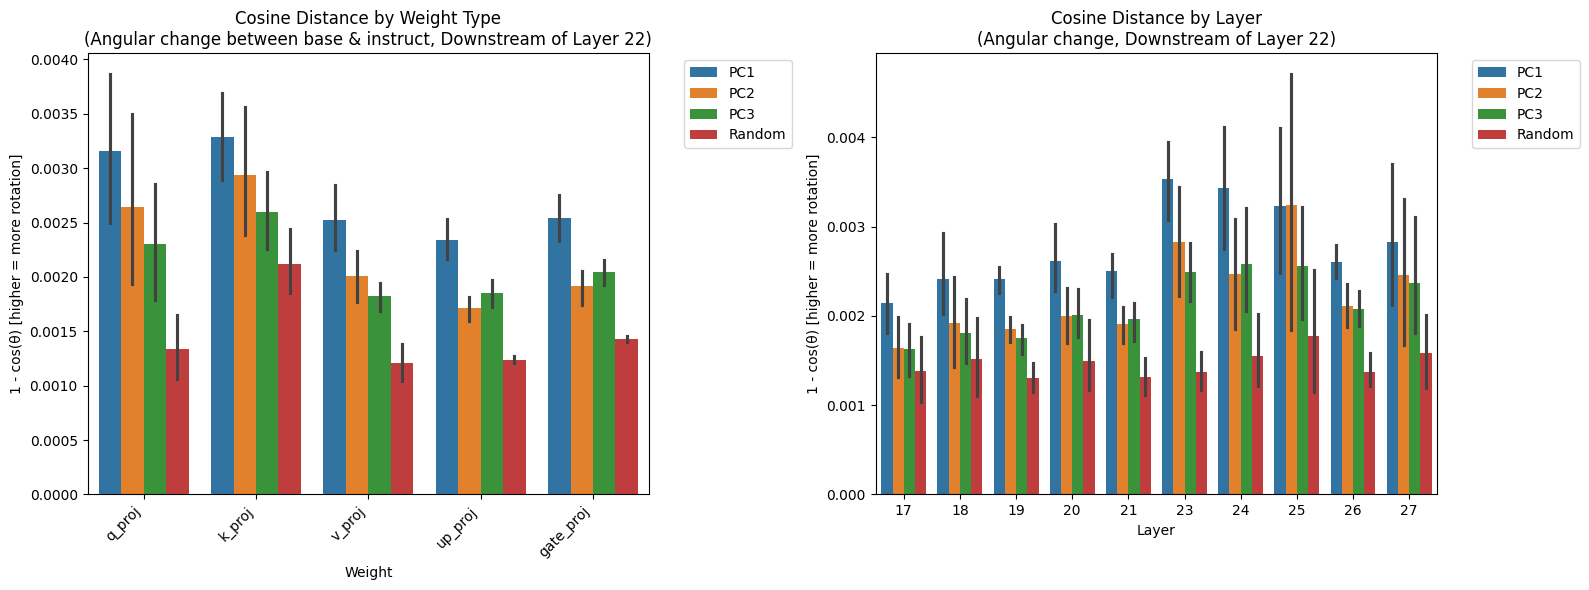


COSINE DISTANCE - 1 - cos(θ)
Higher = more angular change (rotation) between base and instruct

By weight type:
PC            PC1     PC2     PC3  Random
Weight                                   
q_proj     0.0032  0.0026  0.0023  0.0013
k_proj     0.0033  0.0029  0.0026  0.0021
v_proj     0.0025  0.0020  0.0018  0.0012
up_proj    0.0023  0.0017  0.0019  0.0012
gate_proj  0.0025  0.0019  0.0020  0.0014

By layer:
PC        PC1     PC2     PC3  Random
Layer                                
17     0.0021  0.0016  0.0016  0.0014
18     0.0024  0.0019  0.0018  0.0015
19     0.0024  0.0018  0.0018  0.0013
20     0.0026  0.0020  0.0020  0.0015
21     0.0025  0.0019  0.0020  0.0013
23     0.0035  0.0028  0.0025  0.0014
24     0.0034  0.0025  0.0026  0.0015
25     0.0032  0.0032  0.0026  0.0018
26     0.0026  0.0021  0.0021  0.0014
27     0.0028  0.0025  0.0024  0.0016

OVERALL SUMMARY (mean across all weights)
PC
PC1       0.0028
PC2       0.0022
PC3       0.0021
Random    0.0015
Name: Cosine

In [39]:
# Visualize results - Focus on Cosine Distance
import pandas as pd

# Convert results to DataFrame
rows = []
for weight_name, pc_results in results.items():
    # Extract layer number and weight type
    parts = weight_name.split('.')
    layer_num = int(parts[2])  # model.layers.{layer_num}...
    weight_type = parts[-2]  # Second to last segment (e.g., up_proj, gate_proj, q_proj)
    
    for pc_name, metrics in pc_results.items():
        rows.append({
            'Layer': layer_num,
            'Weight': weight_type,
            'PC': pc_name,
            'Cosine Distance': metrics['cosine_distance'],
            'Full Name': weight_name
        })

df = pd.DataFrame(rows)
print("\nResults summary:")
print(df[['Layer', 'Weight', 'PC', 'Cosine Distance']].round(4))

# Define consistent weight type ordering
weight_order = ['q_proj', 'k_proj', 'v_proj', 'up_proj', 'gate_proj']
weight_order = [w for w in weight_order if w in df['Weight'].unique()]

# Plot: Cosine Distance by weight type and layer
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# By weight type
ax = axes[0]
sns.barplot(data=df, x='Weight', y='Cosine Distance', hue='PC', ax=ax, order=weight_order)
ax.set_title(f'Cosine Distance by Weight Type\n(Angular change between base & instruct, Downstream of Layer {pca_layer})')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_ylabel('1 - cos(θ) [higher = more rotation]')

# By layer
ax = axes[1]
sns.barplot(data=df, x='Layer', y='Cosine Distance', hue='PC', ax=ax)
ax.set_title(f'Cosine Distance by Layer\n(Angular change, Downstream of Layer {pca_layer})')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_ylabel('1 - cos(θ) [higher = more rotation]')

plt.tight_layout()
plt.show()

# Compute statistics
print("\n" + "="*60)
print("COSINE DISTANCE - 1 - cos(θ)")
print("Higher = more angular change (rotation) between base and instruct")
print("="*60)

print("\nBy weight type:")
pivot_weight_cos = df.groupby(['Weight', 'PC'])['Cosine Distance'].mean().reset_index().pivot(
    index='Weight', columns='PC', values='Cosine Distance')
# Reorder rows
pivot_weight_cos = pivot_weight_cos.reindex(weight_order)
print(pivot_weight_cos.round(4))

print("\nBy layer:")
pivot_layer_cos = df.groupby(['Layer', 'PC'])['Cosine Distance'].mean().reset_index().pivot(
    index='Layer', columns='PC', values='Cosine Distance')
print(pivot_layer_cos.round(4))

# Summary statistics
print("\n" + "="*60)
print("OVERALL SUMMARY (mean across all weights)")
print("="*60)
summary_stats = df.groupby('PC')['Cosine Distance'].mean().round(4)
print(summary_stats)

HEATMAP: Cosine Distance by Weight Type and Layer


Creating heatmaps:   0%|          | 0/4 [00:00<?, ?it/s]

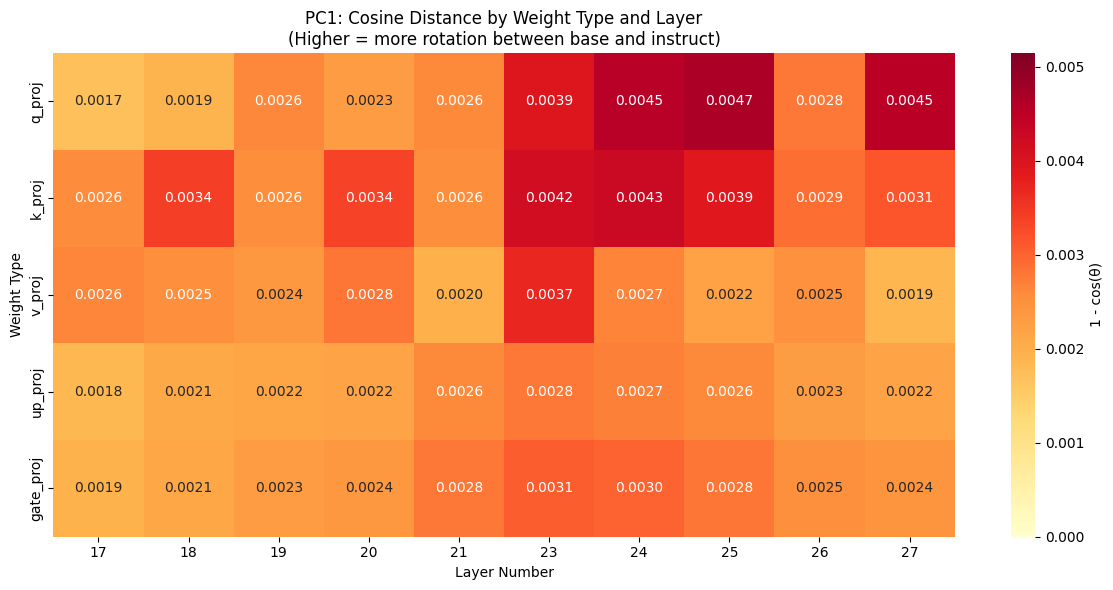

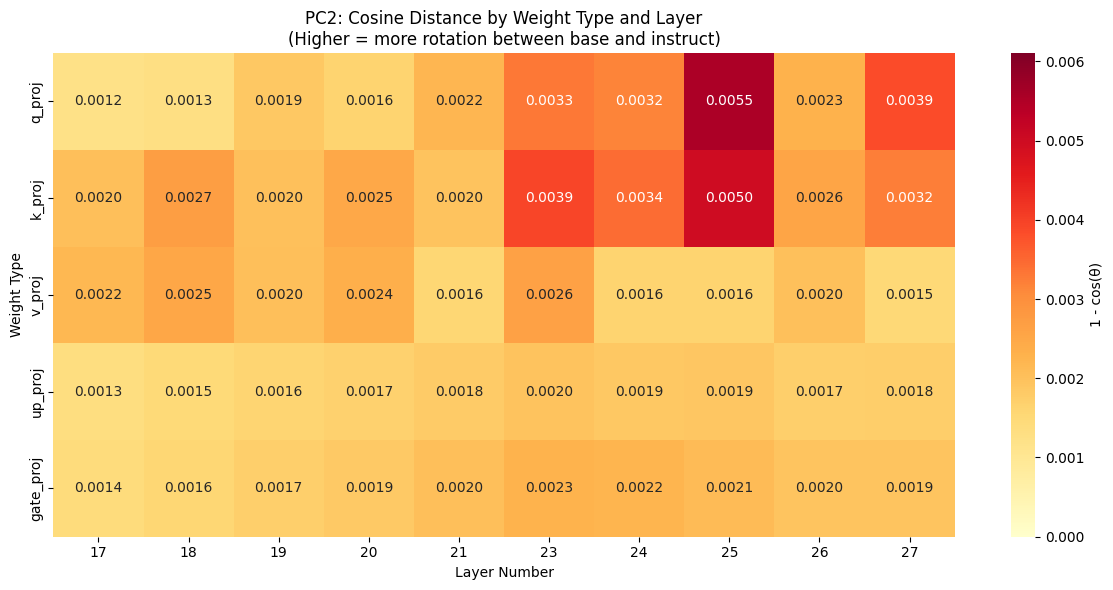

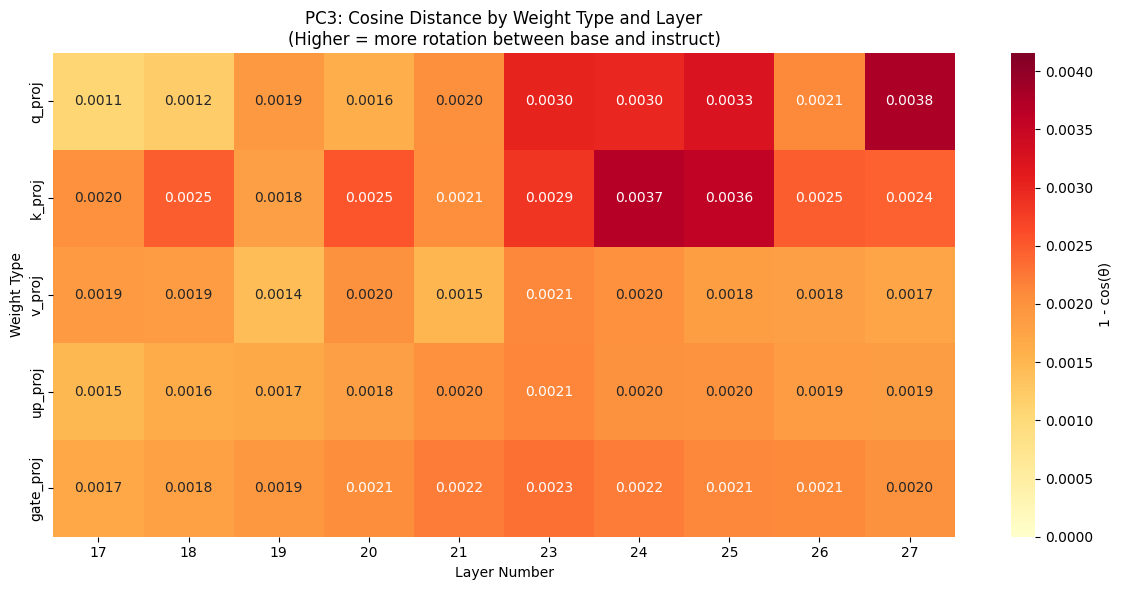

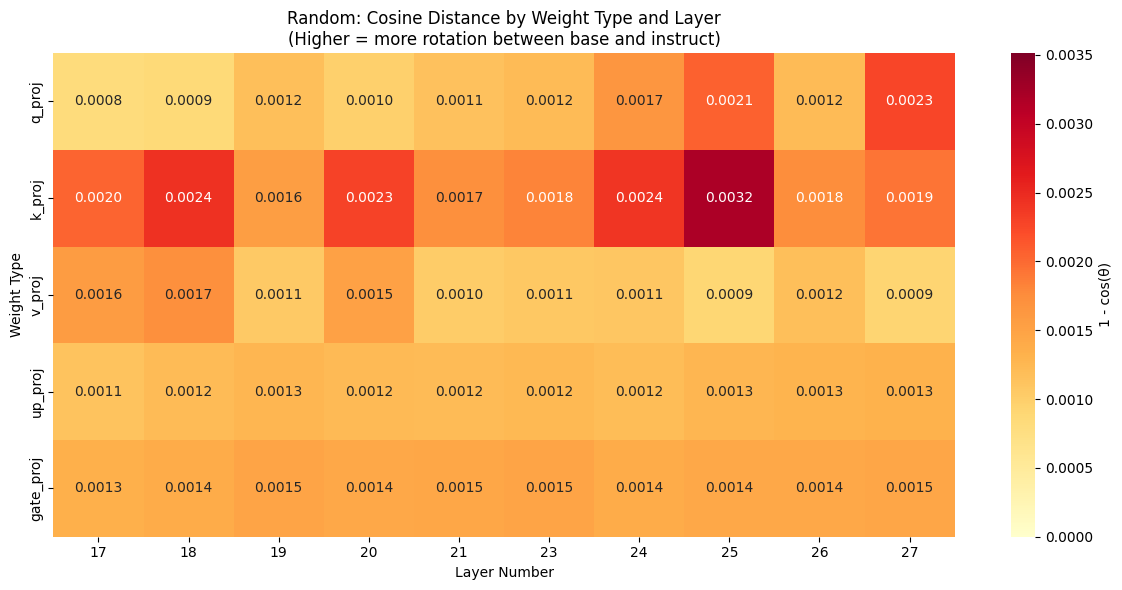


Heatmap Summary Statistics
       PC     Min     Max    Mean
0     PC1  0.0017  0.0047  0.0028
1     PC2  0.0012  0.0055  0.0022
2     PC3  0.0011  0.0038  0.0021
3  Random  0.0008  0.0032  0.0015

RATIO HEATMAP: PC / Random by Weight Type and Layer


Creating ratio heatmaps:   0%|          | 0/3 [00:00<?, ?it/s]

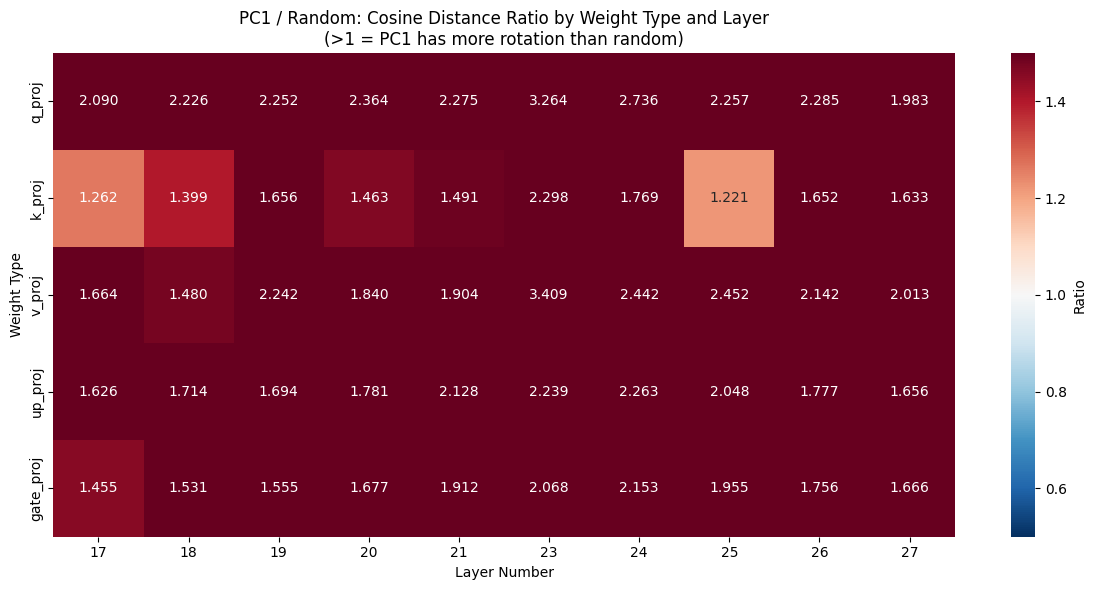

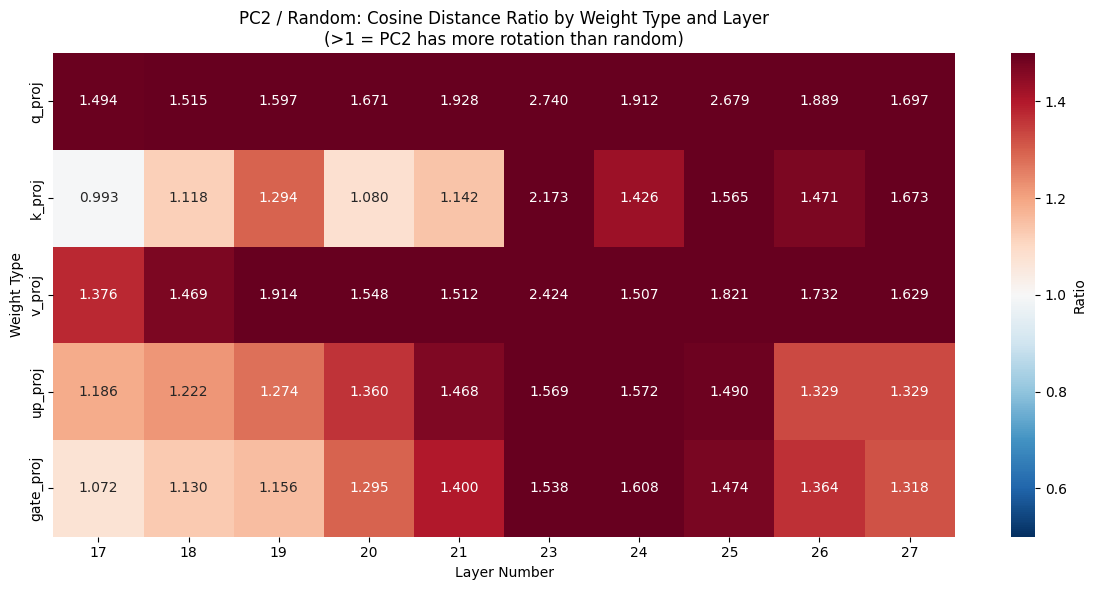

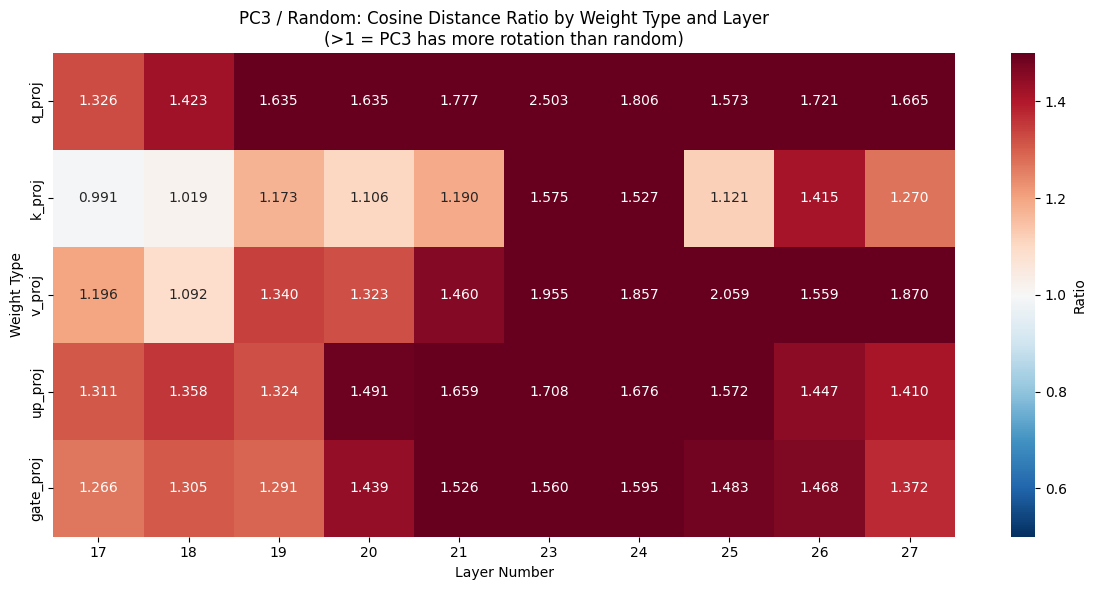


Ratio Heatmap Summary Statistics
          Ratio     Min     Max    Mean
0  PC1 / Random  1.2208  3.4088  1.9564
1  PC2 / Random  0.9932  2.7404  1.5429
2  PC3 / Random  0.9908  2.5029  1.4885


In [40]:
# Create heatmap of cosine distances by weight type and layer
print("="*60)
print("HEATMAP: Cosine Distance by Weight Type and Layer")
print("="*60)

# Define consistent weight type ordering
weight_order = ['q_proj', 'k_proj', 'v_proj', 'up_proj', 'gate_proj']
weight_order = [w for w in weight_order if w in df['Weight'].unique()]

# Collect summary statistics for all PCs
heatmap_stats = []

# Pivot data for heatmap
for pc_name in tqdm(['PC1', 'PC2', 'PC3', 'Random'], desc="Creating heatmaps"):
    if pc_name not in df['PC'].unique():
        continue
    
    pc_df = df[df['PC'] == pc_name].copy()
    
    # Create pivot table: rows = weight type, columns = layer
    heatmap_data = pc_df.pivot_table(
        index='Weight', 
        columns='Layer', 
        values='Cosine Distance',
        aggfunc='mean'
    )
    
    # Reorder rows
    heatmap_data = heatmap_data.reindex(weight_order)
    
    # Plot heatmap
    plt.figure(figsize=(12, 6))
    sns.heatmap(
        heatmap_data, 
        annot=True, 
        fmt='.4f', 
        cmap='YlOrRd',
        cbar_kws={'label': '1 - cos(θ)'},
        vmin=0,
        vmax=heatmap_data.max().max() * 1.1  # Scale to data
    )
    plt.title(f'{pc_name}: Cosine Distance by Weight Type and Layer\n(Higher = more rotation between base and instruct)')
    plt.xlabel('Layer Number')
    plt.ylabel('Weight Type')
    
    # Add vertical line at PCA layer
    pca_layer_col_idx = list(heatmap_data.columns).index(pca_layer) if pca_layer in heatmap_data.columns else None
    if pca_layer_col_idx is not None:
        plt.axvline(x=pca_layer_col_idx + 0.5, color='blue', linestyle='--', linewidth=2, alpha=0.7)
        plt.text(pca_layer_col_idx + 0.5, -0.5, f'PCA Layer {pca_layer}', 
                ha='center', va='top', color='blue', fontsize=10, weight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Collect stats
    heatmap_stats.append({
        'PC': pc_name,
        'Min': heatmap_data.min().min(),
        'Max': heatmap_data.max().max(),
        'Mean': heatmap_data.mean().mean()
    })

# Display summary stats for all heatmaps
print("\n" + "="*60)
print("Heatmap Summary Statistics")
print("="*60)
heatmap_stats_df = pd.DataFrame(heatmap_stats)
print(heatmap_stats_df.round(4))

# Create ratio heatmaps: PC / Random
print("\n" + "="*60)
print("RATIO HEATMAP: PC / Random by Weight Type and Layer")
print("="*60)

# Get pivots for each PC
pc_pivots = {}
for pc_name in ['PC1', 'PC2', 'PC3', 'Random']:
    if pc_name not in df['PC'].unique():
        continue
    pc_df = df[df['PC'] == pc_name].copy()
    pivot = pc_df.pivot_table(
        index='Weight', 
        columns='Layer', 
        values='Cosine Distance',
        aggfunc='mean'
    )
    # Reorder rows
    pc_pivots[pc_name] = pivot.reindex(weight_order)

# Create ratio heatmaps
if 'Random' in pc_pivots:
    ratio_stats = []
    for pc_name in tqdm(['PC1', 'PC2', 'PC3'], desc="Creating ratio heatmaps"):
        if pc_name not in pc_pivots:
            continue
        
        # Compute ratio
        ratio_data = pc_pivots[pc_name] / pc_pivots['Random']
        
        # Plot heatmap
        plt.figure(figsize=(12, 6))
        sns.heatmap(
            ratio_data, 
            annot=True, 
            fmt='.3f', 
            cmap='RdBu_r',
            center=1.0,
            cbar_kws={'label': 'Ratio'},
            vmin=0.5,
            vmax=1.5
        )
        plt.title(f'{pc_name} / Random: Cosine Distance Ratio by Weight Type and Layer\n(>1 = {pc_name} has more rotation than random)')
        plt.xlabel('Layer Number')
        plt.ylabel('Weight Type')
        
        # Add vertical line at PCA layer
        pca_layer_col_idx = list(ratio_data.columns).index(pca_layer) if pca_layer in ratio_data.columns else None
        if pca_layer_col_idx is not None:
            plt.axvline(x=pca_layer_col_idx + 0.5, color='black', linestyle='--', linewidth=2, alpha=0.7)
            plt.text(pca_layer_col_idx + 0.5, -0.5, f'PCA Layer {pca_layer}', 
                    ha='center', va='top', color='black', fontsize=10, weight='bold')
        
        plt.tight_layout()
        plt.show()
        
        # Collect stats
        ratio_stats.append({
            'Ratio': f'{pc_name} / Random',
            'Min': ratio_data.min().min(),
            'Max': ratio_data.max().max(),
            'Mean': ratio_data.mean().mean()
        })
    
    # Display ratio summary stats
    print("\n" + "="*60)
    print("Ratio Heatmap Summary Statistics")
    print("="*60)
    ratio_stats_df = pd.DataFrame(ratio_stats)
    print(ratio_stats_df.round(4))

## 7. Full MLP Forward Pass Analysis

Since the MLP is pointwise, we can run PC vectors through the entire MLP forward pass:
1. `pre_feedforward_layernorm(x)`
2. `gate_proj(x)` → `act_fn` (GELU) 
3. `up_proj(x)`
4. Element-wise multiply: `gate * up`
5. `down_proj(result)`
6. `post_feedforward_layernorm(result)`

This captures the full nonlinear transformation and is more realistic than just analyzing input projections.

In [41]:
# Implement GELU activation (Gemma2 uses 'gelu_pytorch_tanh' approximation)
def gelu_approx(x):
    """GELU activation with tanh approximation (used by Gemma2)."""
    return 0.5 * x * (1.0 + torch.tanh(torch.sqrt(torch.tensor(2.0 / torch.pi)) * (x + 0.044715 * torch.pow(x, 3))))

def full_mlp_forward_batch(x_batch, gate_weight, up_weight, down_weight, 
                           pre_ln_weight, post_ln_weight, eps=1e-6):
    """
    Run full MLP forward pass on a batch of vectors.
    
    Args:
        x_batch: input vectors (n_vectors, hidden_dim)
        gate_weight: gate projection weight
        up_weight: up projection weight  
        down_weight: down projection weight
        pre_ln_weight: pre-feedforward layernorm weight
        post_ln_weight: post-feedforward layernorm weight
        eps: epsilon for RMSNorm
        
    Returns:
        output vectors after full MLP + output layernorm (n_vectors, hidden_dim)
    """
    # 1. Pre-feedforward layernorm (batched)
    x_normed = gemma2_rmsnorm(x_batch, pre_ln_weight, eps=eps)
    
    # 2. Gate projection + GELU activation (batched)
    gate_out = x_normed.float() @ gate_weight.T.float()  # (n_vectors, intermediate_size)
    gate_act = gelu_approx(gate_out)
    
    # 3. Up projection (batched)
    up_out = x_normed.float() @ up_weight.T.float()  # (n_vectors, intermediate_size)
    
    # 4. Element-wise multiply
    mlp_hidden = gate_act * up_out
    
    # 5. Down projection (batched)
    mlp_out = mlp_hidden @ down_weight.T.float()  # (n_vectors, hidden_dim)
    
    # 6. Post-feedforward layernorm (batched)
    output = gemma2_rmsnorm(mlp_out, post_ln_weight, eps=eps)
    
    return output.to(x_batch.dtype)

# Run full MLP forward pass for PC vectors on MLP layers
mlp_results = {}
n_random_baseline = 20

print(f"Computing full MLP forward pass analysis with {n_random_baseline} random baseline vectors")
print(f"Analyzing {len(all_layers)} layers: {all_layers}")
print(f"Including -PC1 (negative PC1 direction)\n")

for layer_num in tqdm(all_layers, desc="Processing MLP layers"):
    # Get all MLP weights
    gate_name = f"model.layers.{layer_num}.mlp.gate_proj.weight"
    up_name = f"model.layers.{layer_num}.mlp.up_proj.weight"
    down_name = f"model.layers.{layer_num}.mlp.down_proj.weight"
    pre_ln_key = f"{layer_num}.pre_feedforward_layernorm"
    post_ln_name = f"model.layers.{layer_num}.post_feedforward_layernorm.weight"
    
    # Check all weights exist
    if not all([
        gate_name in base_state_dict,
        up_name in base_state_dict,
        down_name in base_state_dict,
        pre_ln_key in layernorm_weights,
        post_ln_name in base_state_dict
    ]):
        continue
    
    # Get weights
    gate_base = base_state_dict[gate_name]
    gate_instruct = instruct_state_dict[gate_name]
    up_base = base_state_dict[up_name]
    up_instruct = instruct_state_dict[up_name]
    down_base = base_state_dict[down_name]
    down_instruct = instruct_state_dict[down_name]
    
    pre_ln_base = layernorm_weights[pre_ln_key]['base']
    pre_ln_instruct = layernorm_weights[pre_ln_key]['instruct']
    post_ln_base = base_state_dict[post_ln_name]
    post_ln_instruct = instruct_state_dict[post_ln_name]
    
    # Collect all vectors to test
    all_vectors = []
    vector_names = []
    
    # Add PC1
    all_vectors.append(pc1)
    vector_names.append('PC1')
    
    # Add -PC1 (negative direction)
    all_vectors.append(-pc1)
    vector_names.append('-PC1')
    
    # Add PC2 if available
    if pc2 is not None:
        all_vectors.append(pc2)
        vector_names.append('PC2')
    
    # Add PC3 if available
    if pc3 is not None:
        all_vectors.append(pc3)
        vector_names.append('PC3')
    
    # Add random vectors
    for i in range(n_random_baseline):
        random_vec = torch.randn_like(pc1)
        random_vec = random_vec / random_vec.norm()
        all_vectors.append(random_vec)
        vector_names.append(f'Random_{i}')
    
    # Stack into batch
    vectors_batch = torch.stack(all_vectors)  # (n_vectors, hidden_dim)
    
    # Run batched MLP forward
    out_base = full_mlp_forward_batch(
        vectors_batch, gate_base, up_base, down_base,
        pre_ln_base, post_ln_base, eps=config.rms_norm_eps
    )
    
    out_instruct = full_mlp_forward_batch(
        vectors_batch, gate_instruct, up_instruct, down_instruct,
        pre_ln_instruct, post_ln_instruct, eps=config.rms_norm_eps
    )
    
    # Compute cosine distances for all vectors
    out_base_f = out_base.float()
    out_instruct_f = out_instruct.float()
    
    # Compute norms
    base_norms = out_base_f.norm(dim=1)  # (n_vectors,)
    instruct_norms = out_instruct_f.norm(dim=1)  # (n_vectors,)
    
    # Compute dot products
    dot_products = (out_base_f * out_instruct_f).sum(dim=1)  # (n_vectors,)
    
    # Compute cosine similarities
    cos_sims = dot_products / (base_norms * instruct_norms + 1e-8)
    cos_dists = 1.0 - cos_sims
    
    # Store results
    layer_results = {}
    for name, cos_dist in zip(vector_names, cos_dists.cpu().numpy()):
        if name.startswith('Random_'):
            continue
        layer_results[name] = {'cosine_distance': cos_dist}
    
    # Average random vectors
    random_indices = [i for i, name in enumerate(vector_names) if name.startswith('Random_')]
    if random_indices:
        random_cos_dists = [cos_dists[i].item() for i in random_indices]
        layer_results['Random'] = {'cosine_distance': np.mean(random_cos_dists)}
    
    mlp_results[f"layer_{layer_num}_mlp"] = layer_results

print(f"\n✓ Completed MLP analysis for {len(mlp_results)} layers")

Computing full MLP forward pass analysis with 20 random baseline vectors
Analyzing 10 layers: [17, 18, 19, 20, 21, 23, 24, 25, 26, 27]
Including -PC1 (negative PC1 direction)



Processing MLP layers:   0%|          | 0/10 [00:00<?, ?it/s]


✓ Completed MLP analysis for 10 layers


DIFFERENTIAL ANALYSIS: Which weight types show strongest PC1 effects?

COSINE DISTANCE - Ratios
Higher ratio = more angular change for PC

PC ratios:
PC            PC1     PC2  Random  PC1 / PC2  PC1 / Random  PC2 / Random  \
Weight                                                                     
q_proj     0.0032  0.0026  0.0013     1.1965        2.3601        1.9725   
k_proj     0.0033  0.0029  0.0021     1.1182        1.5538        1.3896   
v_proj     0.0025  0.0020  0.0012     1.2568        2.0896        1.6626   
up_proj    0.0023  0.0017  0.0012     1.3702        1.8917        1.3806   
gate_proj  0.0025  0.0019  0.0014     1.3273        1.7747        1.3371   

PC            PC3  PC3 / Random  
Weight                           
q_proj     0.0023        1.7177  
k_proj     0.0026        1.2277  
v_proj     0.0018        1.5109  
up_proj    0.0019        1.4958  
gate_proj  0.0020        1.4314  


/tmp/ipykernel_2382328/1280173306.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_2382328/1280173306.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


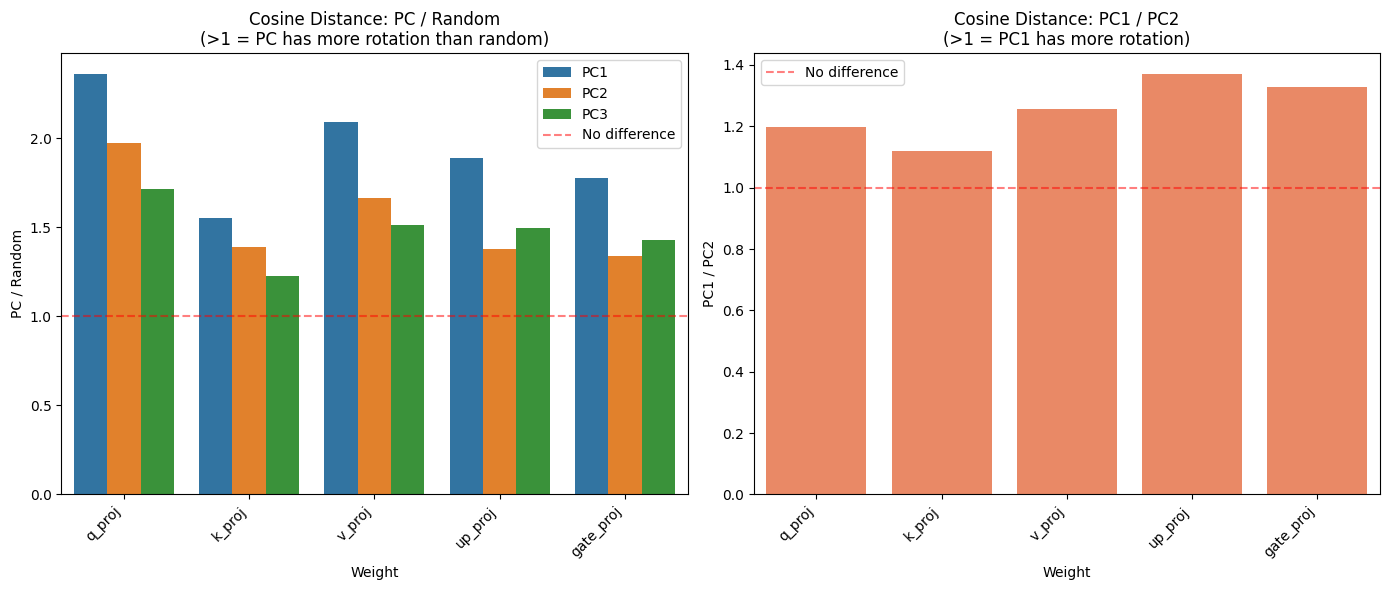


TOP WEIGHT TYPES: Where PC1 stands out most

Top 3 by Cosine Distance (PC1 / Random):
PC          PC1  Random  PC1 / Random
Weight                               
q_proj   0.0032  0.0013        2.3601
v_proj   0.0025  0.0012        2.0896
up_proj  0.0023  0.0012        1.8917

Top 3 by Cosine Distance (PC1 / PC2):
PC            PC1     PC2  PC1 / PC2
Weight                              
up_proj    0.0023  0.0017     1.3702
gate_proj  0.0025  0.0019     1.3273
v_proj     0.0025  0.0020     1.2568

SMOKING GUN: Weight types with strong PC1-specific effects

Cosine Distance - Combined score ((PC1/Rand - 1) * (PC1/PC2 - 1)):
PC         PC1 / Random  PC1 / PC2  Combined
Weight                                      
up_proj          1.8917     1.3702    0.3301
v_proj           2.0896     1.2568    0.2798
q_proj           2.3601     1.1965    0.2673
gate_proj        1.7747     1.3273    0.2536
k_proj           1.5538     1.1182    0.0654

INTERPRETATION GUIDE

Ratios > 1 mean PC has more angul

In [42]:
## Differential Analysis: PC1 vs PC2 and PC1 vs Random

# Define consistent weight type ordering
weight_order = ['q_proj', 'k_proj', 'v_proj', 'up_proj', 'gate_proj']
weight_order = [w for w in weight_order if w in df['Weight'].unique()]

# Compute ratios for each weight type
print("="*80)
print("DIFFERENTIAL ANALYSIS: Which weight types show strongest PC1 effects?")
print("="*80)

# Group by weight type and compute means
weight_summary = df.groupby(['Weight', 'PC'])['Cosine Distance'].mean().reset_index()

# Pivot to get PC columns
pivot_cos = weight_summary.pivot(index='Weight', columns='PC', values='Cosine Distance')

# Reorder rows
pivot_cos = pivot_cos.reindex(weight_order)

# Compute ratios
if 'PC1' in pivot_cos.columns and 'PC2' in pivot_cos.columns and 'Random' in pivot_cos.columns:
    # Cosine Distance ratios
    pivot_cos['PC1 / PC2'] = pivot_cos['PC1'] / pivot_cos['PC2']
    pivot_cos['PC1 / Random'] = pivot_cos['PC1'] / pivot_cos['Random']
    pivot_cos['PC2 / Random'] = pivot_cos['PC2'] / pivot_cos['Random']
    
    if 'PC3' in pivot_cos.columns:
        pivot_cos['PC3 / Random'] = pivot_cos['PC3'] / pivot_cos['Random']
    
    print("\n" + "="*60)
    print("COSINE DISTANCE - Ratios")
    print("Higher ratio = more angular change for PC")
    print("="*60)
    print("\nPC ratios:")
    ratio_cols = ['PC1', 'PC2', 'Random', 'PC1 / PC2', 'PC1 / Random', 'PC2 / Random']
    if 'PC3' in pivot_cos.columns:
        ratio_cols.extend(['PC3', 'PC3 / Random'])
    print(pivot_cos[ratio_cols].round(4))
    
    # Visualize the ratios with colors for all PCs
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # PC / Random ratios by weight type
    ax = axes[0]
    ratio_data = []
    for weight in pivot_cos.index:
        ratio_data.append({'Weight': weight, 'PC': 'PC1', 'Ratio': pivot_cos.loc[weight, 'PC1 / Random']})
        ratio_data.append({'Weight': weight, 'PC': 'PC2', 'Ratio': pivot_cos.loc[weight, 'PC2 / Random']})
        if 'PC3 / Random' in pivot_cos.columns:
            ratio_data.append({'Weight': weight, 'PC': 'PC3', 'Ratio': pivot_cos.loc[weight, 'PC3 / Random']})
    
    ratio_df = pd.DataFrame(ratio_data)
    sns.barplot(data=ratio_df, x='Weight', y='Ratio', hue='PC', ax=ax, order=weight_order)
    ax.axhline(1.0, color='red', linestyle='--', alpha=0.5, label='No difference')
    ax.set_title('Cosine Distance: PC / Random\n(>1 = PC has more rotation than random)')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_ylabel('PC / Random')
    ax.legend()
    
    # PC1 / PC2 by weight type (keep this one focused on PC1)
    ax = axes[1]
    diff_data = pivot_cos[['PC1 / PC2']].reset_index()
    sns.barplot(data=diff_data, x='Weight', y='PC1 / PC2', ax=ax, color='coral', order=weight_order)
    ax.axhline(1.0, color='red', linestyle='--', alpha=0.5, label='No difference')
    ax.set_title('Cosine Distance: PC1 / PC2\n(>1 = PC1 has more rotation)')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_ylabel('PC1 / PC2')
    ax.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Identify top weight types
    print("\n" + "="*60)
    print("TOP WEIGHT TYPES: Where PC1 stands out most")
    print("="*60)
    
    print("\nTop 3 by Cosine Distance (PC1 / Random):")
    top_cos_random = pivot_cos.nlargest(3, 'PC1 / Random')[['PC1', 'Random', 'PC1 / Random']]
    print(top_cos_random.round(4))
    
    print("\nTop 3 by Cosine Distance (PC1 / PC2):")
    top_cos_pc2 = pivot_cos.nlargest(3, 'PC1 / PC2')[['PC1', 'PC2', 'PC1 / PC2']]
    print(top_cos_pc2.round(4))
    
    # Identify "smoking gun" weight types - high on BOTH comparisons
    print("\n" + "="*60)
    print("SMOKING GUN: Weight types with strong PC1-specific effects")
    print("="*60)
    
    # For cosine distance: high PC1/Random AND high PC1/PC2
    pivot_cos['Combined'] = (pivot_cos['PC1 / Random'] - 1) * (pivot_cos['PC1 / PC2'] - 1)
    print("\nCosine Distance - Combined score ((PC1/Rand - 1) * (PC1/PC2 - 1)):")
    print(pivot_cos[['PC1 / Random', 'PC1 / PC2', 'Combined']].sort_values('Combined', ascending=False).round(4))
    
    # Summary interpretation
    print("\n" + "="*60)
    print("INTERPRETATION GUIDE")
    print("="*60)
    print("""
Ratios > 1 mean PC has more angular change (rotation) than the baseline.

'PC / Random' > 1:
  → PC gets rotated more by instruction tuning than random directions
  → Instruction tuning specifically changes how this PC activates downstream

'PC1 / PC2' > 1:
  → PC1 gets rotated more than PC2 (the 2nd highest-variance direction)
  → The effect is specific to PC1, not just any high-variance PC

Weight types with high 'Combined score':
  → Show PC1-SPECIFIC instruction tuning effects
  → Strong evidence that SFT rotates PC1 activations in these weights
  → Top weights are where the PC1/persona axis is being modified
    """)

else:
    print("Could not compute ratios - missing PC columns")

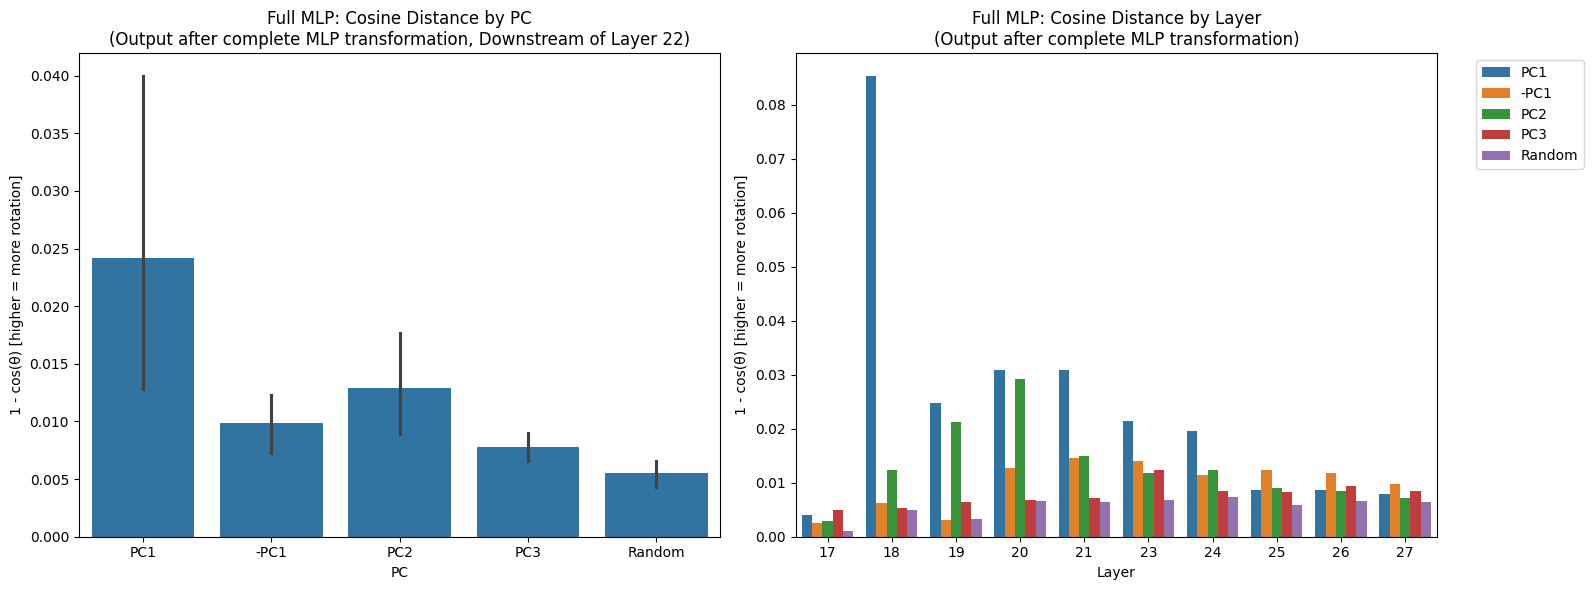


FULL MLP FORWARD PASS - Cosine Distance

By layer:
PC        PC1    -PC1     PC2     PC3  Random
Layer                                        
17     0.0040  0.0025  0.0029  0.0049  0.0011
18     0.0853  0.0063  0.0123  0.0053  0.0050
19     0.0247  0.0031  0.0212  0.0063  0.0033
20     0.0308  0.0126  0.0292  0.0067  0.0065
21     0.0308  0.0146  0.0149  0.0072  0.0064
23     0.0214  0.0140  0.0117  0.0123  0.0068
24     0.0195  0.0114  0.0123  0.0085  0.0074
25     0.0086  0.0123  0.0090  0.0083  0.0059
26     0.0087  0.0118  0.0085  0.0094  0.0066
27     0.0079  0.0098  0.0072  0.0084  0.0065

Overall summary:
PC
PC1       0.0242
-PC1      0.0098
PC2       0.0129
PC3       0.0077
Random    0.0055
Name: Cosine Distance, dtype: float64

FULL MLP - PC / Random Ratios (mean across layers)
  PC1 / Random: 4.7412
 -PC1 / Random: 1.7669
  PC2 / Random: 2.5596
  PC3 / Random: 1.6593

PC1 vs -PC1 Comparison

By layer:
PC        PC1    -PC1  PC1 / -PC1
Layer                            
17   

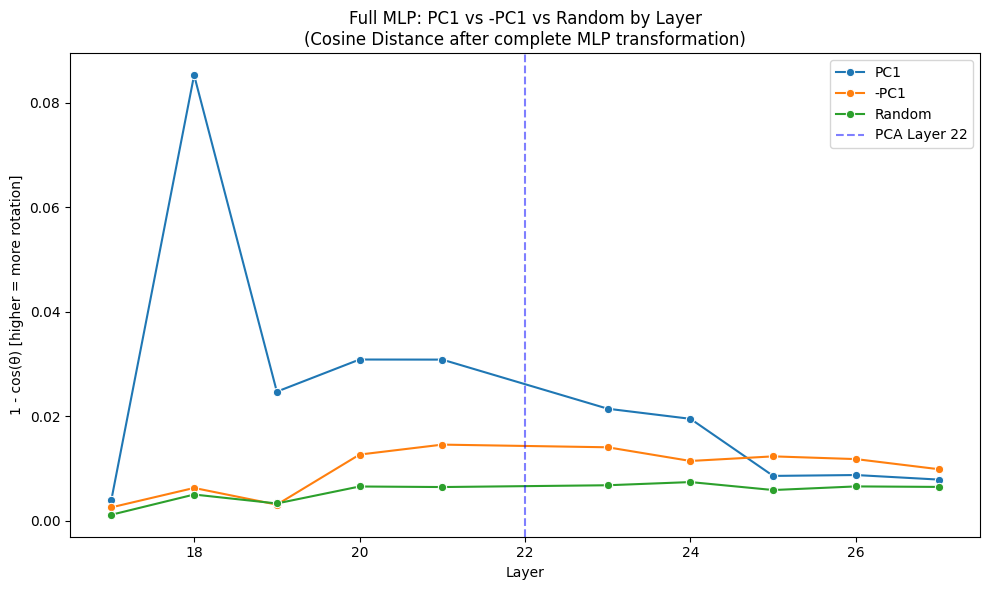

In [43]:
# Visualize MLP results
mlp_rows = []
for layer_name, pc_results in mlp_results.items():
    # Extract layer number
    layer_num = int(layer_name.split('_')[1])
    
    for pc_name, metrics in pc_results.items():
        mlp_rows.append({
            'Layer': layer_num,
            'PC': pc_name,
            'Cosine Distance': metrics['cosine_distance']
        })

mlp_df = pd.DataFrame(mlp_rows)

# Plot MLP results
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# By PC
ax = axes[0]
pc_order = ['PC1', '-PC1', 'PC2', 'PC3', 'Random']
pc_order = [pc for pc in pc_order if pc in mlp_df['PC'].unique()]
sns.barplot(data=mlp_df, x='PC', y='Cosine Distance', ax=ax, order=pc_order)
ax.set_title(f'Full MLP: Cosine Distance by PC\n(Output after complete MLP transformation, Downstream of Layer {pca_layer})')
ax.set_ylabel('1 - cos(θ) [higher = more rotation]')

# By layer (separate lines for PC1 vs -PC1 vs Random)
ax = axes[1]
# Filter to just PC1, -PC1, and Random for cleaner comparison
comparison_df = mlp_df[mlp_df['PC'].isin(['PC1', '-PC1', 'PC2', 'PC3', 'Random'])]
sns.barplot(data=comparison_df, x='Layer', y='Cosine Distance', hue='PC', ax=ax, hue_order=pc_order)
ax.set_title(f'Full MLP: Cosine Distance by Layer\n(Output after complete MLP transformation)')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_ylabel('1 - cos(θ) [higher = more rotation]')

plt.tight_layout()
plt.show()

# Statistics
print("\n" + "="*60)
print("FULL MLP FORWARD PASS - Cosine Distance")
print("="*60)

print("\nBy layer:")
mlp_pivot = mlp_df.groupby(['Layer', 'PC'])['Cosine Distance'].mean().reset_index().pivot(
    index='Layer', columns='PC', values='Cosine Distance')
# Reorder columns for better readability
col_order = ['PC1', '-PC1', 'PC2', 'PC3', 'Random']
col_order = [col for col in col_order if col in mlp_pivot.columns]
print(mlp_pivot[col_order].round(4))

print("\nOverall summary:")
mlp_summary = mlp_df.groupby('PC')['Cosine Distance'].mean().round(4)
print(mlp_summary[pc_order])

# Compute ratios
if 'PC1' in mlp_pivot.columns and 'Random' in mlp_pivot.columns:
    print("\n" + "="*60)
    print("FULL MLP - PC / Random Ratios (mean across layers)")
    print("="*60)
    
    for pc in ['PC1', '-PC1', 'PC2', 'PC3']:
        if pc in mlp_pivot.columns:
            ratio = (mlp_pivot[pc] / mlp_pivot['Random']).mean()
            print(f"{pc:>5} / Random: {ratio:.4f}")

# Compare PC1 vs -PC1 directly
if 'PC1' in mlp_pivot.columns and '-PC1' in mlp_pivot.columns:
    print("\n" + "="*60)
    print("PC1 vs -PC1 Comparison")
    print("="*60)
    
    print("\nBy layer:")
    pc1_vs_neg = mlp_pivot[['PC1', '-PC1']].copy()
    pc1_vs_neg['PC1 / -PC1'] = pc1_vs_neg['PC1'] / pc1_vs_neg['-PC1']
    print(pc1_vs_neg.round(4))
    
    print(f"\nMean PC1 / -PC1 ratio: {pc1_vs_neg['PC1 / -PC1'].mean():.4f}")
    print(f"Mean PC1 cosine distance: {mlp_pivot['PC1'].mean():.4f}")
    print(f"Mean -PC1 cosine distance: {mlp_pivot['-PC1'].mean():.4f}")
    
    # Plot PC1 vs -PC1 by layer
    fig, ax = plt.subplots(figsize=(10, 6))
    comparison_for_plot = mlp_df[mlp_df['PC'].isin(['PC1', '-PC1', 'Random'])]
    sns.lineplot(data=comparison_for_plot, x='Layer', y='Cosine Distance', hue='PC', 
                 marker='o', ax=ax, hue_order=['PC1', '-PC1', 'Random'])
    ax.set_title('Full MLP: PC1 vs -PC1 vs Random by Layer\n(Cosine Distance after complete MLP transformation)')
    ax.set_ylabel('1 - cos(θ) [higher = more rotation]')
    ax.axvline(x=pca_layer, color='blue', linestyle='--', alpha=0.5, label=f'PCA Layer {pca_layer}')
    ax.legend()
    plt.tight_layout()
    plt.show()

MLP DIFFERENTIAL ANALYSIS: PC effects in full MLP transformation

MLP COSINE DISTANCE - Ratios
Higher ratio = more angular change for PC in full MLP output

MLP PC ratios by layer:
PC        PC1    -PC1     PC2     PC3  Random  PC1 / Random  -PC1 / Random  \
Layer                                                                        
17     0.0040  0.0025  0.0029  0.0049  0.0011        3.5405         2.2483   
18     0.0853  0.0063  0.0123  0.0053  0.0050       17.0487         1.2520   
19     0.0247  0.0031  0.0212  0.0063  0.0033        7.5057         0.9319   
20     0.0308  0.0126  0.0292  0.0067  0.0065        4.7160         1.9341   
21     0.0308  0.0146  0.0149  0.0072  0.0064        4.7905         2.2619   
23     0.0214  0.0140  0.0117  0.0123  0.0068        3.1610         2.0721   
24     0.0195  0.0114  0.0123  0.0085  0.0074        2.6387         1.5467   
25     0.0086  0.0123  0.0090  0.0083  0.0059        1.4612         2.0993   
26     0.0087  0.0118  0.0085  0.0094  

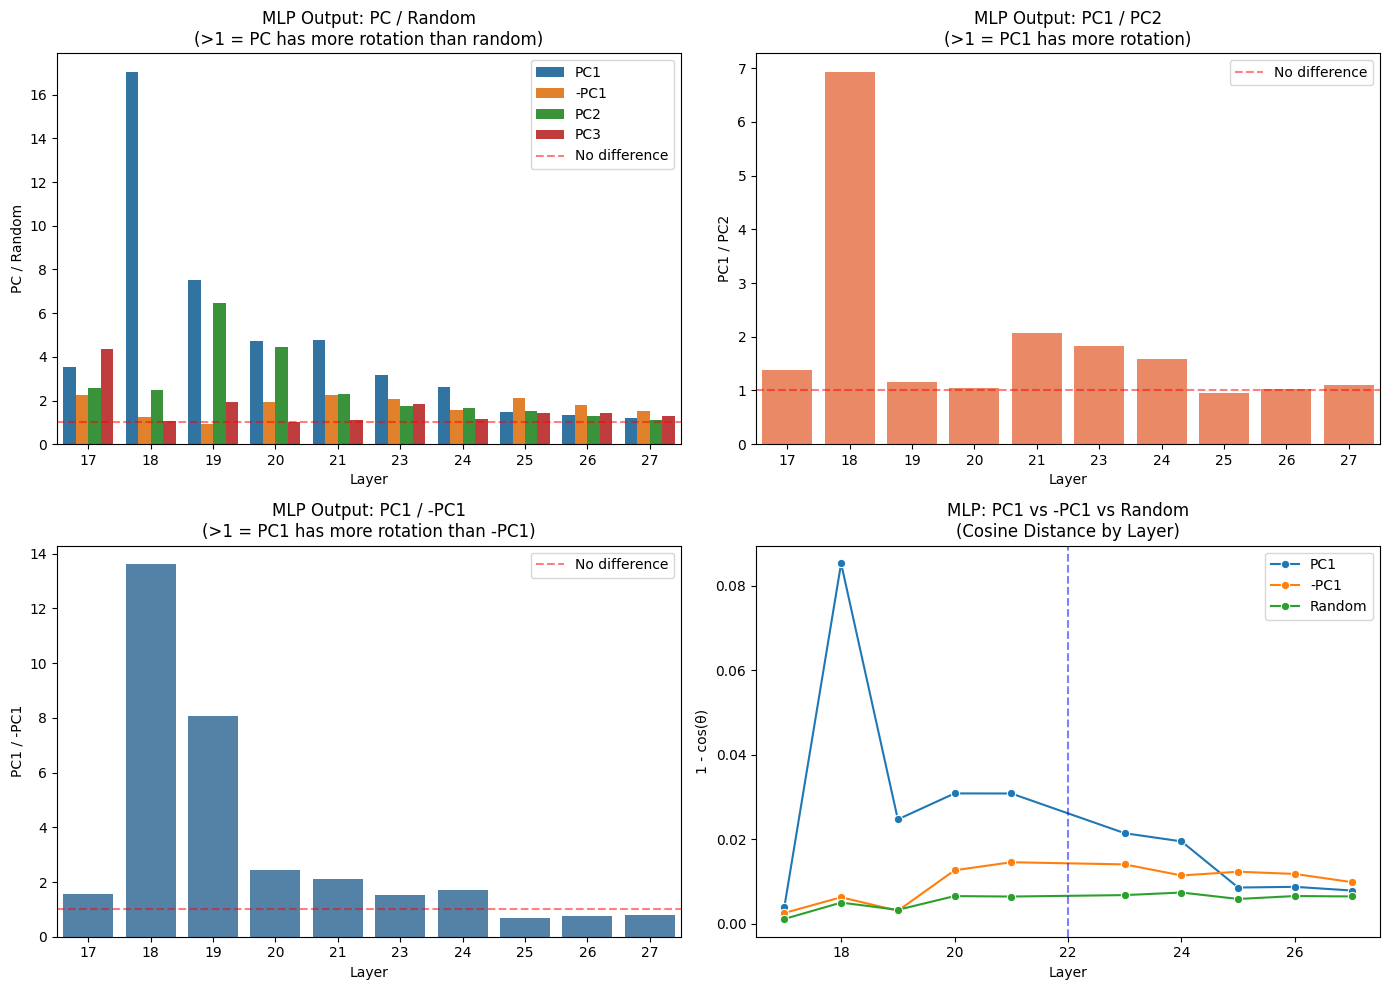


MLP OVERALL AVERAGES

Mean PC / Random ratios (averaged across layers):
    PC1 / Random: 4.7412
   -PC1 / Random: 1.7669
    PC2 / Random: 2.5596
    PC3 / Random: 1.6593

Mean PC1 / PC2 ratio: 1.9089
Mean PC1 / -PC1 ratio: 3.3269

SMOKING GUN: Layers with strong PC1-specific MLP effects

MLP Cosine Distance - Combined score ((PC1/Rand - 1) * (PC1/PC2 - 1)):
PC     PC1 / Random  PC1 / PC2  PC1 / -PC1  Combined
Layer                                               
18          17.0487     6.9324     13.6171   95.2079
21           4.7905     2.0638      2.1179    4.0323
23           3.1610     1.8294      1.5255    1.7924
19           7.5057     1.1630      8.0543    1.0606
17           3.5405     1.3810      1.5748    0.9680
24           2.6387     1.5878      1.7060    0.9633
20           4.7160     1.0552      2.4383    0.2051
27           1.2172     1.0976      0.7983    0.0212
26           1.3324     1.0226      0.7411    0.0075
25           1.4612     0.9564      0.6960   -0.0201



In [44]:
## Differential Analysis: MLP Full Forward Pass

# Compute ratios for MLP results
print("="*80)
print("MLP DIFFERENTIAL ANALYSIS: PC effects in full MLP transformation")
print("="*80)

# Pivot MLP data
mlp_pivot = mlp_df.groupby(['Layer', 'PC'])['Cosine Distance'].mean().reset_index().pivot(
    index='Layer', columns='PC', values='Cosine Distance')

# Compute ratios
if 'PC1' in mlp_pivot.columns and 'Random' in mlp_pivot.columns:
    # Cosine Distance ratios
    for pc in ['PC1', '-PC1', 'PC2', 'PC3']:
        if pc in mlp_pivot.columns:
            mlp_pivot[f'{pc} / Random'] = mlp_pivot[pc] / mlp_pivot['Random']
    
    if 'PC1' in mlp_pivot.columns and 'PC2' in mlp_pivot.columns:
        mlp_pivot['PC1 / PC2'] = mlp_pivot['PC1'] / mlp_pivot['PC2']
    
    if 'PC1' in mlp_pivot.columns and '-PC1' in mlp_pivot.columns:
        mlp_pivot['PC1 / -PC1'] = mlp_pivot['PC1'] / mlp_pivot['-PC1']
    
    print("\n" + "="*60)
    print("MLP COSINE DISTANCE - Ratios")
    print("Higher ratio = more angular change for PC in full MLP output")
    print("="*60)
    print("\nMLP PC ratios by layer:")
    
    ratio_cols = []
    base_cols = []
    for pc in ['PC1', '-PC1', 'PC2', 'PC3', 'Random']:
        if pc in mlp_pivot.columns:
            base_cols.append(pc)
    
    for pc in ['PC1', '-PC1', 'PC2', 'PC3']:
        if f'{pc} / Random' in mlp_pivot.columns:
            ratio_cols.append(f'{pc} / Random')
    
    if 'PC1 / PC2' in mlp_pivot.columns:
        ratio_cols.append('PC1 / PC2')
    if 'PC1 / -PC1' in mlp_pivot.columns:
        ratio_cols.append('PC1 / -PC1')
    
    print(mlp_pivot[base_cols + ratio_cols].round(4))
    
    # Visualize the ratios with colors for all PCs
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # 1. PC / Random ratios by layer
    ax = axes[0, 0]
    mlp_ratio_data = []
    for layer in mlp_pivot.index:
        for pc in ['PC1', '-PC1', 'PC2', 'PC3']:
            if f'{pc} / Random' in mlp_pivot.columns:
                mlp_ratio_data.append({
                    'Layer': layer, 
                    'PC': pc, 
                    'Ratio': mlp_pivot.loc[layer, f'{pc} / Random']
                })
    
    if mlp_ratio_data:
        mlp_ratio_df = pd.DataFrame(mlp_ratio_data)
        pc_order = ['PC1', '-PC1', 'PC2', 'PC3']
        pc_order = [pc for pc in pc_order if pc in mlp_ratio_df['PC'].unique()]
        sns.barplot(data=mlp_ratio_df, x='Layer', y='Ratio', hue='PC', ax=ax, hue_order=pc_order)
        ax.axhline(1.0, color='red', linestyle='--', alpha=0.5, label='No difference')
        ax.set_title('MLP Output: PC / Random\n(>1 = PC has more rotation than random)')
        ax.set_ylabel('PC / Random')
        ax.legend()
    
    # 2. PC1 / PC2 by layer
    ax = axes[0, 1]
    if 'PC1 / PC2' in mlp_pivot.columns:
        mlp_pc1_pc2_data = mlp_pivot[['PC1 / PC2']].reset_index()
        sns.barplot(data=mlp_pc1_pc2_data, x='Layer', y='PC1 / PC2', ax=ax, color='coral')
        ax.axhline(1.0, color='red', linestyle='--', alpha=0.5, label='No difference')
        ax.set_title('MLP Output: PC1 / PC2\n(>1 = PC1 has more rotation)')
        ax.set_ylabel('PC1 / PC2')
        ax.legend()
    
    # 3. PC1 / -PC1 by layer
    ax = axes[1, 0]
    if 'PC1 / -PC1' in mlp_pivot.columns:
        mlp_pc1_neg_data = mlp_pivot[['PC1 / -PC1']].reset_index()
        sns.barplot(data=mlp_pc1_neg_data, x='Layer', y='PC1 / -PC1', ax=ax, color='steelblue')
        ax.axhline(1.0, color='red', linestyle='--', alpha=0.5, label='No difference')
        ax.set_title('MLP Output: PC1 / -PC1\n(>1 = PC1 has more rotation than -PC1)')
        ax.set_ylabel('PC1 / -PC1')
        ax.legend()
    
    # 4. Combined: PC1 vs -PC1 vs Random line plot
    ax = axes[1, 1]
    comparison_for_plot = mlp_df[mlp_df['PC'].isin(['PC1', '-PC1', 'Random'])]
    sns.lineplot(data=comparison_for_plot, x='Layer', y='Cosine Distance', hue='PC', 
                 marker='o', ax=ax, hue_order=['PC1', '-PC1', 'Random'])
    ax.set_title('MLP: PC1 vs -PC1 vs Random\n(Cosine Distance by Layer)')
    ax.set_ylabel('1 - cos(θ)')
    ax.axvline(x=pca_layer, color='blue', linestyle='--', alpha=0.5)
    ax.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Overall averages
    print("\n" + "="*60)
    print("MLP OVERALL AVERAGES")
    print("="*60)
    
    print("\nMean PC / Random ratios (averaged across layers):")
    for pc in ['PC1', '-PC1', 'PC2', 'PC3']:
        if f'{pc} / Random' in mlp_pivot.columns:
            ratio = mlp_pivot[f'{pc} / Random'].mean()
            print(f"  {pc:>5} / Random: {ratio:.4f}")
    
    if 'PC1 / PC2' in mlp_pivot.columns:
        print(f"\nMean PC1 / PC2 ratio: {mlp_pivot['PC1 / PC2'].mean():.4f}")
    
    if 'PC1 / -PC1' in mlp_pivot.columns:
        print(f"Mean PC1 / -PC1 ratio: {mlp_pivot['PC1 / -PC1'].mean():.4f}")
    
    # Identify "smoking gun" layers - high on BOTH PC1/Random AND PC1/PC2
    print("\n" + "="*60)
    print("SMOKING GUN: Layers with strong PC1-specific MLP effects")
    print("="*60)
    
    # For cosine distance: high PC1/Random AND high PC1/PC2
    if 'PC1 / Random' in mlp_pivot.columns and 'PC1 / PC2' in mlp_pivot.columns:
        mlp_pivot['Combined'] = (mlp_pivot['PC1 / Random'] - 1) * (mlp_pivot['PC1 / PC2'] - 1)
        print("\nMLP Cosine Distance - Combined score ((PC1/Rand - 1) * (PC1/PC2 - 1)):")
        display_cols = ['PC1 / Random', 'PC1 / PC2', 'Combined']
        if 'PC1 / -PC1' in mlp_pivot.columns:
            display_cols.insert(2, 'PC1 / -PC1')
        print(mlp_pivot[display_cols].sort_values('Combined', ascending=False).round(4))
    
    # Summary interpretation
    print("\n" + "="*60)
    print("MLP INTERPRETATION")
    print("="*60)
    print("""
These ratios measure the FULL MLP transformation (input → output).

'PC / Random' > 1:
  → After full MLP, PC output differs more between base and instruct than random
  → Instruction tuning specifically modifies how this PC is transformed by the MLP
  → Captures nonlinear effects from GELU activation

'PC1 / PC2' > 1:
  → PC1 output changes more than PC2 output through the full MLP
  → The effect is specific to PC1, not just high-variance PCs

'PC1 / -PC1' ratio:
  → Measures asymmetry in how instruction tuning affects positive vs negative PC1
  → If ratio ≈ 1: instruction tuning affects both directions equally (symmetric)
  → If ratio > 1: PC1 (+) direction affected more than -PC1 (-) direction
  → If ratio < 1: -PC1 (-) direction affected more than PC1 (+) direction
  
Higher ratios here are MORE significant than input projection ratios because:
  → They measure the complete transformation (not just first step)
  → They include nonlinear activation effects
  → They include both pre and post layernorm effects
    """)

else:
    print("Could not compute MLP ratios - missing PC columns")

PC1 COMPONENT ANALYSIS: MLP Output Projection onto PC1

This analysis checks whether instruction tuning changes how much PC1 remains
in the MLP output. If the instruct model reduces the PC1 component, it suggests
active suppression of the persona axis.


Analyzing PC1 components for 10 layers



Analyzing PC1 components:   0%|          | 0/10 [00:00<?, ?it/s]


PC1 COMPONENT STATISTICS

PC1 → MLP Output PC1 Component:
  Mean Base:     +674.674
  Mean Instruct: +632.089
  Mean Delta:    -42.585
  % layers where instruct reduces PC1: 100.0%
  % layers where signs differ: 0.0%

-PC1 → MLP Output PC1 Component:
  Mean Base:     -772.235
  Mean Instruct: -755.272
  Mean Delta:    +16.963
  % layers where instruct reduces PC1: 0.0%
  % layers where signs differ: 0.0%

PC2 → MLP Output PC1 Component:
  Mean Base:     -9.377
  Mean Instruct: -24.561
  Mean Delta:    -15.183
  % layers where instruct reduces PC1: 100.0%
  % layers where signs differ: 20.0%

PC3 → MLP Output PC1 Component:
  Mean Base:     -64.395
  Mean Instruct: -75.511
  Mean Delta:    -11.117
  % layers where instruct reduces PC1: 90.0%
  % layers where signs differ: 0.0%


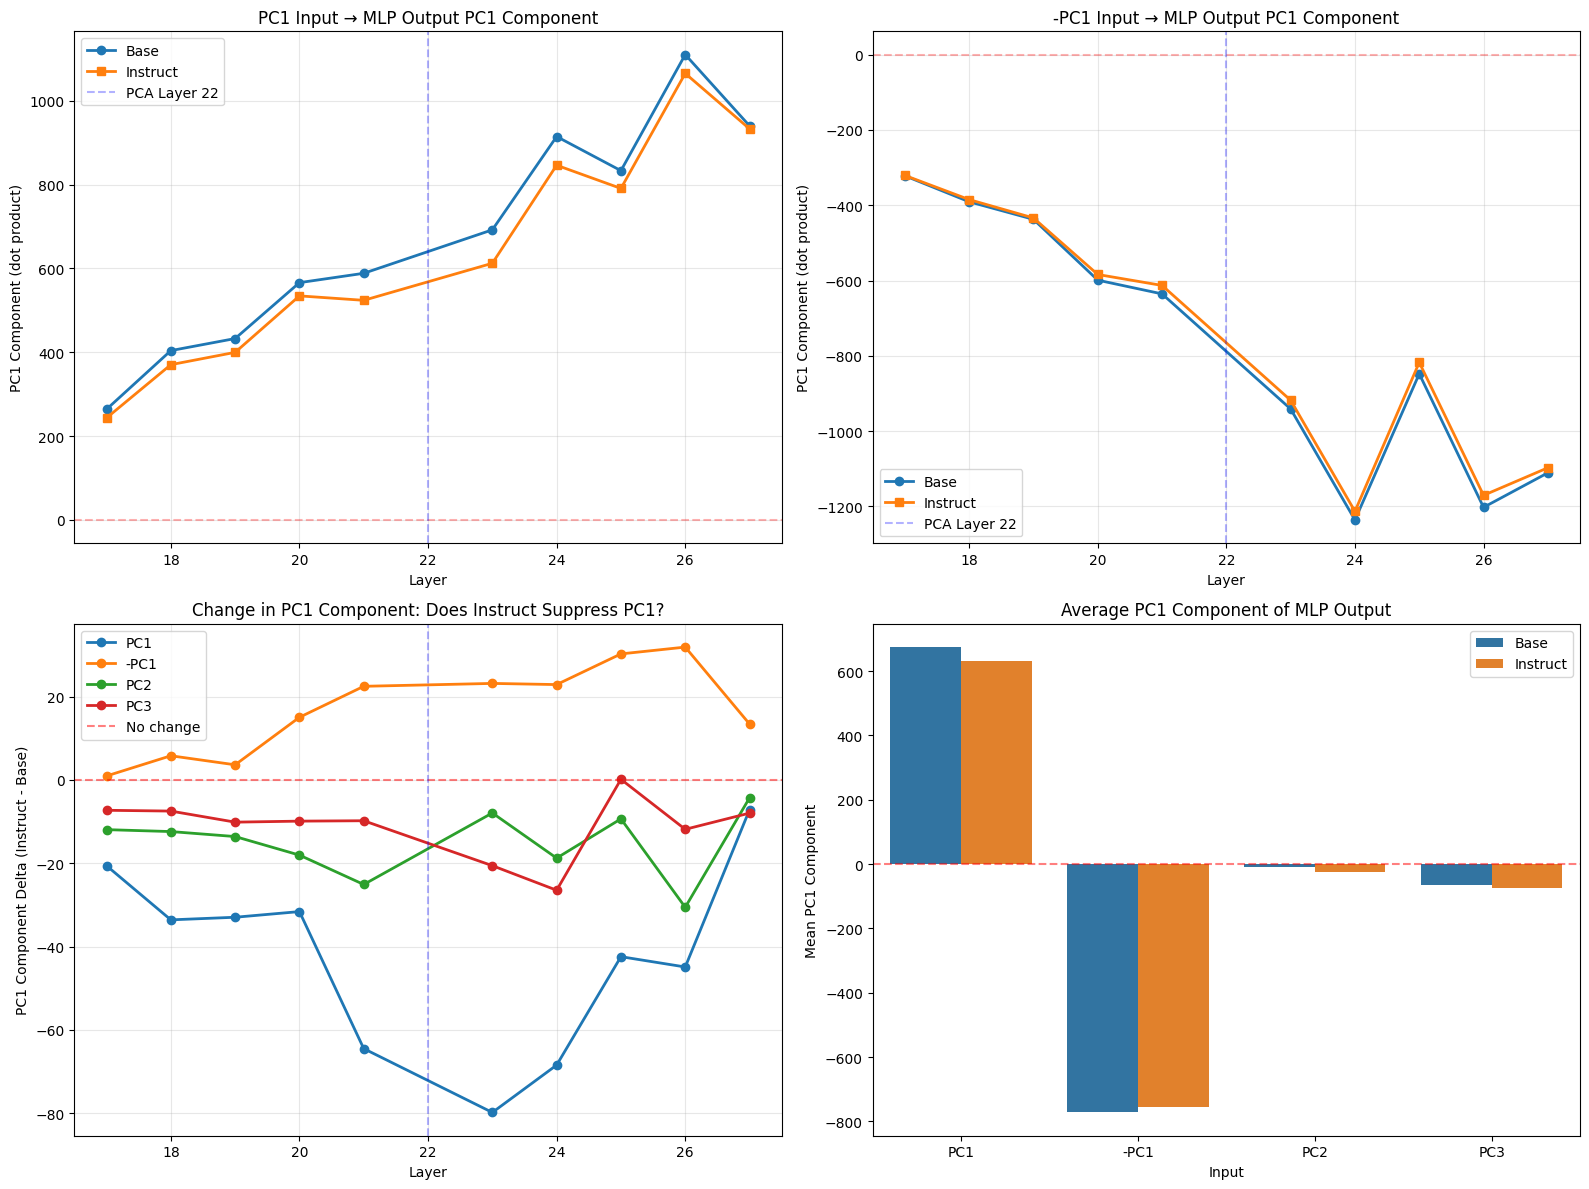


LAYER-BY-LAYER: PC1 Input → MLP Output PC1 Component
    Layer  PC1_Component_Base  PC1_Component_Instruct  PC1_Component_Delta
0      17            264.0501                243.4694             -20.5807
4      18            404.0649                370.4930             -33.5719
8      19            432.8547                399.9087             -32.9460
12     20            566.2219                534.6339             -31.5880
16     21            588.5083                524.0258             -64.4825
20     23            692.2427                612.4423             -79.8004
24     24            914.7759                846.3430             -68.4329
28     25            833.3952                790.9847             -42.4105
32     26           1110.3115               1065.4268             -44.8848
36     27            940.3181                933.1670              -7.1511

INTERPRETATION

PC1 Component = (MLP_output · PC1)

Positive value: Output aligns with +PC1 direction
Negative value: Ou

In [45]:
## PC1 Component Analysis: Does Instruct Model Suppress PC1?

print("="*80)
print("PC1 COMPONENT ANALYSIS: MLP Output Projection onto PC1")
print("="*80)
print("""
This analysis checks whether instruction tuning changes how much PC1 remains
in the MLP output. If the instruct model reduces the PC1 component, it suggests
active suppression of the persona axis.
""")

# Analyze PC1 component for each layer's MLP
pc1_component_results = []

print(f"\nAnalyzing PC1 components for {len(all_layers)} layers\n")

for layer_num in tqdm(all_layers, desc="Analyzing PC1 components"):
    # Get all MLP weights
    gate_name = f"model.layers.{layer_num}.mlp.gate_proj.weight"
    up_name = f"model.layers.{layer_num}.mlp.up_proj.weight"
    down_name = f"model.layers.{layer_num}.mlp.down_proj.weight"
    pre_ln_key = f"{layer_num}.pre_feedforward_layernorm"
    post_ln_name = f"model.layers.{layer_num}.post_feedforward_layernorm.weight"
    
    # Check all weights exist
    if not all([
        gate_name in base_state_dict,
        up_name in base_state_dict,
        down_name in base_state_dict,
        pre_ln_key in layernorm_weights,
        post_ln_name in base_state_dict
    ]):
        continue
    
    # Get weights
    gate_base = base_state_dict[gate_name]
    gate_instruct = instruct_state_dict[gate_name]
    up_base = base_state_dict[up_name]
    up_instruct = instruct_state_dict[up_name]
    down_base = base_state_dict[down_name]
    down_instruct = instruct_state_dict[down_name]
    
    pre_ln_base = layernorm_weights[pre_ln_key]['base']
    pre_ln_instruct = layernorm_weights[pre_ln_key]['instruct']
    post_ln_base = base_state_dict[post_ln_name]
    post_ln_instruct = instruct_state_dict[post_ln_name]
    
    # Test vectors: PC1, -PC1, PC2, PC3
    test_vectors = {
        'PC1': pc1,
        '-PC1': -pc1,
        'PC2': pc2 if pc2 is not None else None,
        'PC3': pc3 if pc3 is not None else None,
    }
    
    for vec_name, vec in test_vectors.items():
        if vec is None:
            continue
        
        # Run through MLP (base model)
        out_base = full_mlp_forward_batch(
            vec.unsqueeze(0), gate_base, up_base, down_base,
            pre_ln_base, post_ln_base, eps=config.rms_norm_eps
        ).squeeze(0)
        
        # Run through MLP (instruct model)
        out_instruct = full_mlp_forward_batch(
            vec.unsqueeze(0), gate_instruct, up_instruct, down_instruct,
            pre_ln_instruct, post_ln_instruct, eps=config.rms_norm_eps
        ).squeeze(0)
        
        # Project outputs back onto PC1 to get PC1 component
        pc1_component_base = (out_base.float() @ pc1.float()).item()
        pc1_component_instruct = (out_instruct.float() @ pc1.float()).item()
        
        # Also compute output norms for normalization
        norm_base = out_base.float().norm().item()
        norm_instruct = out_instruct.float().norm().item()
        
        # Normalized PC1 component (as fraction of total magnitude)
        pc1_frac_base = pc1_component_base / (norm_base + 1e-8)
        pc1_frac_instruct = pc1_component_instruct / (norm_instruct + 1e-8)
        
        pc1_component_results.append({
            'Layer': layer_num,
            'Input': vec_name,
            'PC1_Component_Base': pc1_component_base,
            'PC1_Component_Instruct': pc1_component_instruct,
            'PC1_Component_Delta': pc1_component_instruct - pc1_component_base,
            'PC1_Frac_Base': pc1_frac_base,
            'PC1_Frac_Instruct': pc1_frac_instruct,
            'PC1_Frac_Delta': pc1_frac_instruct - pc1_frac_base,
            'Norm_Base': norm_base,
            'Norm_Instruct': norm_instruct,
        })

# Convert to DataFrame
pc1_comp_df = pd.DataFrame(pc1_component_results)

print("\n" + "="*60)
print("PC1 COMPONENT STATISTICS")
print("="*60)

# Show results by input vector
for vec_name in ['PC1', '-PC1', 'PC2', 'PC3']:
    if vec_name not in pc1_comp_df['Input'].unique():
        continue
    
    vec_df = pc1_comp_df[pc1_comp_df['Input'] == vec_name]
    
    print(f"\n{vec_name} → MLP Output PC1 Component:")
    print(f"  Mean Base:     {vec_df['PC1_Component_Base'].mean():+.3f}")
    print(f"  Mean Instruct: {vec_df['PC1_Component_Instruct'].mean():+.3f}")
    print(f"  Mean Delta:    {vec_df['PC1_Component_Delta'].mean():+.3f}")
    print(f"  % layers where instruct reduces PC1: {(vec_df['PC1_Component_Delta'] < 0).sum() / len(vec_df) * 100:.1f}%")
    print(f"  % layers where signs differ: {((vec_df['PC1_Component_Base'] * vec_df['PC1_Component_Instruct']) < 0).sum() / len(vec_df) * 100:.1f}%")

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. PC1 component by layer for PC1 input
ax = axes[0, 0]
pc1_input_df = pc1_comp_df[pc1_comp_df['Input'] == 'PC1']
ax.plot(pc1_input_df['Layer'], pc1_input_df['PC1_Component_Base'], 
        marker='o', label='Base', linewidth=2)
ax.plot(pc1_input_df['Layer'], pc1_input_df['PC1_Component_Instruct'], 
        marker='s', label='Instruct', linewidth=2)
ax.axhline(0, color='red', linestyle='--', alpha=0.3)
ax.axvline(pca_layer, color='blue', linestyle='--', alpha=0.3, label=f'PCA Layer {pca_layer}')
ax.set_xlabel('Layer')
ax.set_ylabel('PC1 Component (dot product)')
ax.set_title('PC1 Input → MLP Output PC1 Component')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. PC1 component by layer for -PC1 input
ax = axes[0, 1]
neg_pc1_input_df = pc1_comp_df[pc1_comp_df['Input'] == '-PC1']
ax.plot(neg_pc1_input_df['Layer'], neg_pc1_input_df['PC1_Component_Base'], 
        marker='o', label='Base', linewidth=2)
ax.plot(neg_pc1_input_df['Layer'], neg_pc1_input_df['PC1_Component_Instruct'], 
        marker='s', label='Instruct', linewidth=2)
ax.axhline(0, color='red', linestyle='--', alpha=0.3)
ax.axvline(pca_layer, color='blue', linestyle='--', alpha=0.3, label=f'PCA Layer {pca_layer}')
ax.set_xlabel('Layer')
ax.set_ylabel('PC1 Component (dot product)')
ax.set_title('-PC1 Input → MLP Output PC1 Component')
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Delta (Instruct - Base) by layer
ax = axes[1, 0]
for vec_name in ['PC1', '-PC1', 'PC2', 'PC3']:
    if vec_name in pc1_comp_df['Input'].unique():
        vec_df = pc1_comp_df[pc1_comp_df['Input'] == vec_name]
        ax.plot(vec_df['Layer'], vec_df['PC1_Component_Delta'], 
                marker='o', label=vec_name, linewidth=2)
ax.axhline(0, color='red', linestyle='--', alpha=0.5, label='No change')
ax.axvline(pca_layer, color='blue', linestyle='--', alpha=0.3)
ax.set_xlabel('Layer')
ax.set_ylabel('PC1 Component Delta (Instruct - Base)')
ax.set_title('Change in PC1 Component: Does Instruct Suppress PC1?')
ax.legend()
ax.grid(True, alpha=0.3)

# 4. Comparison bar chart
ax = axes[1, 1]
summary_data = []
for vec_name in ['PC1', '-PC1', 'PC2', 'PC3']:
    if vec_name in pc1_comp_df['Input'].unique():
        vec_df = pc1_comp_df[pc1_comp_df['Input'] == vec_name]
        summary_data.append({
            'Input': vec_name,
            'Model': 'Base',
            'Mean PC1 Component': vec_df['PC1_Component_Base'].mean()
        })
        summary_data.append({
            'Input': vec_name,
            'Model': 'Instruct',
            'Mean PC1 Component': vec_df['PC1_Component_Instruct'].mean()
        })

summary_df = pd.DataFrame(summary_data)
sns.barplot(data=summary_df, x='Input', y='Mean PC1 Component', hue='Model', ax=ax)
ax.axhline(0, color='red', linestyle='--', alpha=0.5)
ax.set_ylabel('Mean PC1 Component')
ax.set_title('Average PC1 Component of MLP Output')
ax.legend()

plt.tight_layout()
plt.show()

# Print detailed layer-by-layer comparison for PC1
print("\n" + "="*60)
print("LAYER-BY-LAYER: PC1 Input → MLP Output PC1 Component")
print("="*60)
pc1_input_df_sorted = pc1_input_df.sort_values('Layer')[['Layer', 'PC1_Component_Base', 'PC1_Component_Instruct', 'PC1_Component_Delta']]
print(pc1_input_df_sorted.round(4))

print("\n" + "="*60)
print("INTERPRETATION")
print("="*60)
print("""
PC1 Component = (MLP_output · PC1)

Positive value: Output aligns with +PC1 direction
Negative value: Output aligns with -PC1 direction

If Instruct < Base: Instruction tuning REDUCES PC1 component
If Instruct > Base: Instruction tuning AMPLIFIES PC1 component

Sign flip: When Base and Instruct have opposite signs, instruction tuning
is actively REVERSING the direction along the PC1 axis.
""")

LAYER 18 ANALYSIS: What does instruction tuning DO to PC1?

We run PC1 through layer 18's MLP (both base and instruct), then decompose
the difference vector onto existing role/trait vectors to understand the
semantic meaning of the transformation.


Analyzing layer 18 (the 'smoking gun' layer)

Running PC1 through layer 18 MLP...
Output shapes:
  Base output: torch.Size([4608])
  Instruct output: torch.Size([4608])
  Difference: torch.Size([4608])
  Difference norm: 485.7257

Sanity check - Difference projection onto PC1: -33.6024
(This tells us if instruct increases or decreases PC1 component)

Loading role vectors from PCA data for semantic decomposition
Layer 18 PCA file not found, using layer 22 vectors...

Extracting role vectors from PCA data...
Available vector types: ['pos_2', 'pos_3']
  pos_2: 173 vectors
  pos_3: 275 vectors

Total role vectors loaded: 448

Loading trait vectors...

Total role+trait vectors loaded: 448

Projecting difference onto role/trait vectors


Computing projections:   0%|          | 0/448 [00:00<?, ?it/s]


Projection statistics:
  Min: +0.9085
  Max: +0.9294
  Mean: +0.9214
  Median: +0.9219
  Std: 0.0040
  Positive: 448 / 448 (100.0%)
  Negative: 0 / 448 (0.0%)

STRONGEST PROJECTIONS (by absolute value)

Top 20 strongest projections:
  +0.9294: pos_2_nutritionist
  +0.9292: pos_3_proofreader
  +0.9291: pos_2_veterinarian
  +0.9286: pos_2_proofreader
  +0.9286: pos_2_tutor
  +0.9284: pos_2_biologist
  +0.9284: pos_2_archaeologist
  +0.9282: pos_2_historian
  +0.9282: pos_2_presenter
  +0.9281: pos_2_paramedic
  +0.9281: pos_2_curator
  +0.9279: pos_2_pharmacist
  +0.9278: pos_2_trainer
  +0.9277: pos_2_geographer
  +0.9277: pos_2_statistician
  +0.9277: pos_2_chemist
  +0.9277: pos_2_teacher
  +0.9276: pos_2_physicist
  +0.9274: pos_2_librarian
  +0.9273: pos_2_playwright

POSITIVE LOADINGS: Instruction tuning moves PC1 TOWARD these
Total positive: 448

Top 15 positive projections:
  +0.9294: pos_2_nutritionist
  +0.9292: pos_3_proofreader
  +0.9291: pos_2_veterinarian
  +0.9286: pos_2_

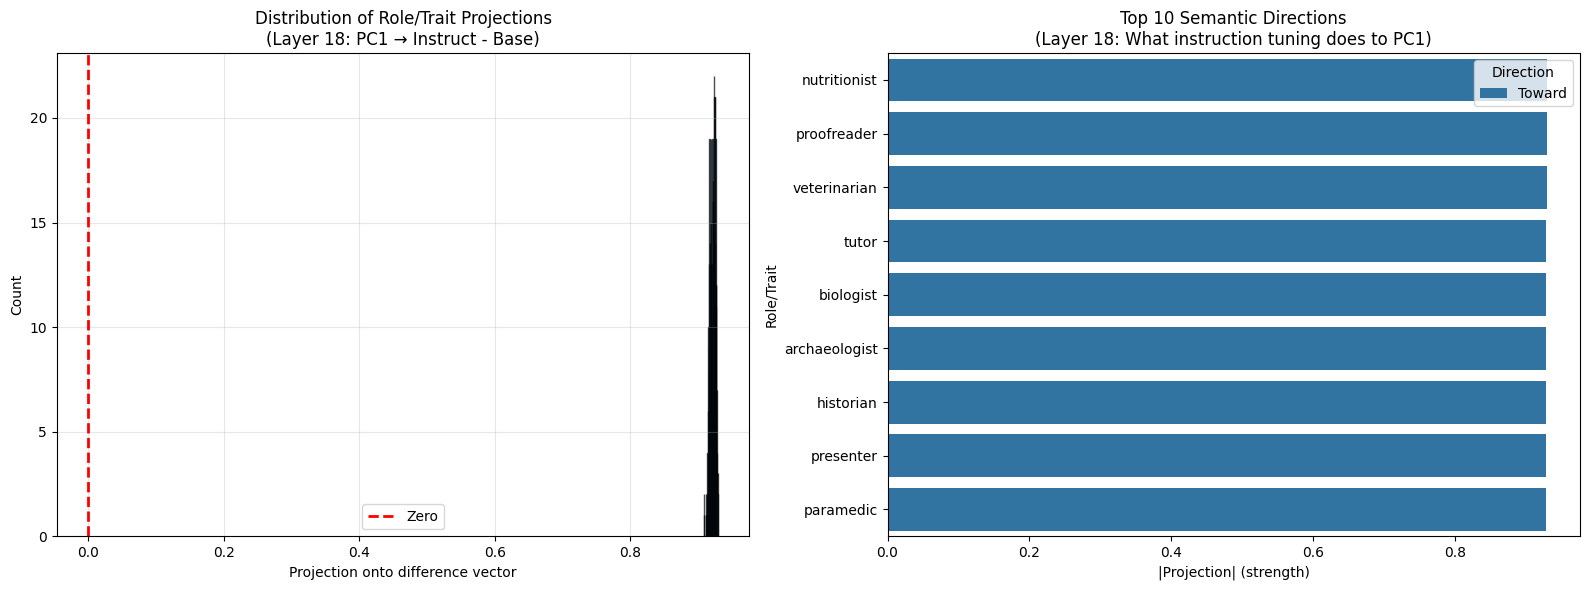


INTERPRETATION

The difference vector (Instruct - Base) shows what instruction tuning ADDS
to PC1's transformation in layer 18.

Positive projections: Instruction tuning moves PC1 toward these semantic directions
Negative projections: Instruction tuning moves PC1 away from these semantic directions

If all projections are positive with no negatives, this suggests instruction tuning
is purely ADDITIVE - it adds new semantic content to PC1 without removing existing content.
This is consistent with the equilibrium-seeking behavior where the model learns to
counterbalance PC1 rather than erase it.



In [124]:
## Layer 18 Deep Dive: Semantic Decomposition of PC1 Transformation

print("="*80)
print("LAYER 18 ANALYSIS: What does instruction tuning DO to PC1?")
print("="*80)
print("""
We run PC1 through layer 18's MLP (both base and instruct), then decompose
the difference vector onto existing role/trait vectors to understand the
semantic meaning of the transformation.
""")

# Target layer
target_layer = 18
print(f"\nAnalyzing layer {target_layer} (the 'smoking gun' layer)\n")

# Get layer 18 MLP weights
gate_name = f"model.layers.{target_layer}.mlp.gate_proj.weight"
up_name = f"model.layers.{target_layer}.mlp.up_proj.weight"
down_name = f"model.layers.{target_layer}.mlp.down_proj.weight"
pre_ln_key = f"{target_layer}.pre_feedforward_layernorm"
post_ln_name = f"model.layers.{target_layer}.post_feedforward_layernorm.weight"

gate_base = base_state_dict[gate_name]
gate_instruct = instruct_state_dict[gate_name]
up_base = base_state_dict[up_name]
up_instruct = instruct_state_dict[up_name]
down_base = base_state_dict[down_name]
down_instruct = instruct_state_dict[down_name]

pre_ln_base = layernorm_weights[pre_ln_key]['base']
pre_ln_instruct = layernorm_weights[pre_ln_key]['instruct']
post_ln_base = base_state_dict[post_ln_name]
post_ln_instruct = instruct_state_dict[post_ln_name]

# Run PC1 through layer 18 MLP
print("Running PC1 through layer 18 MLP...")
out_base = full_mlp_forward_batch(
    pc1.unsqueeze(0), gate_base, up_base, down_base,
    pre_ln_base, post_ln_base, eps=config.rms_norm_eps
).squeeze(0)

out_instruct = full_mlp_forward_batch(
    pc1.unsqueeze(0), gate_instruct, up_instruct, down_instruct,
    pre_ln_instruct, post_ln_instruct, eps=config.rms_norm_eps
).squeeze(0)

# Compute the difference: what instruction tuning ADDS to PC1's transformation
diff_vector = out_instruct - out_base

print(f"Output shapes:")
print(f"  Base output: {out_base.shape}")
print(f"  Instruct output: {out_instruct.shape}")
print(f"  Difference: {diff_vector.shape}")
print(f"  Difference norm: {diff_vector.float().norm().item():.4f}")

# Sanity check: project onto PC1 itself
pc1_proj = (diff_vector.float() @ pc1.float()).item() / pc1.float().norm().item()
print(f"\nSanity check - Difference projection onto PC1: {pc1_proj:+.4f}")
print("(This tells us if instruct increases or decreases PC1 component)")

# Load role vectors from PCA data - we already have this loaded!
print("\n" + "="*60)
print("Loading role vectors from PCA data for semantic decomposition")
print("="*60)

# The pca_data we loaded earlier has role vectors
# Load role PCA data for layer 18 if different from layer 22
layer18_pca_file = persona_data_root / gemma_model_name / "roles_240" / "pca" / f"layer{target_layer}_pos23.pt"

if layer18_pca_file.exists():
    print(f"Loading PCA data for layer {target_layer}...")
    layer18_pca_data = torch.load(layer18_pca_file, map_location='cpu', weights_only=False)
else:
    print(f"Layer {target_layer} PCA file not found, using layer {pca_layer} vectors...")
    layer18_pca_data = pca_data

# Extract role vectors and labels
all_role_vectors = {}
role_vectors_dict = layer18_pca_data['vectors']
role_labels_dict = layer18_pca_data['roles']

print(f"\nExtracting role vectors from PCA data...")
print(f"Available vector types: {list(role_vectors_dict.keys())}")

for vector_type in role_vectors_dict.keys():
    vectors = role_vectors_dict[vector_type]  # List of tensors
    labels = role_labels_dict[vector_type]  # List of strings
    
    print(f"  {vector_type}: {len(vectors)} vectors")
    
    for vec, label in zip(vectors, labels):
        # vec is shape (n_layers, hidden_dim) or just (hidden_dim)
        if vec.dim() == 2:
            # Extract the target layer
            vec_at_layer = vec[target_layer].float()
        else:
            vec_at_layer = vec.float()
        
        # Store with a unique name
        all_role_vectors[f"{vector_type}_{label}"] = vec_at_layer

print(f"\nTotal role vectors loaded: {len(all_role_vectors)}")

# Also load trait vectors
print("\nLoading trait vectors...")
layer18_traits_pca_file = persona_data_root / gemma_model_name / "traits_240" / "pca" / f"layer{target_layer}_pos-neg50.pt"

if layer18_traits_pca_file.exists():
    print(f"Loading trait PCA data for layer {target_layer}...")
    layer18_traits_pca = torch.load(layer18_traits_pca_file, map_location='cpu', weights_only=False)
    
    trait_vectors_dict = layer18_traits_pca['vectors']
    trait_labels_dict = layer18_traits_pca['roles']  # Note: key is 'roles' even for traits
    
    print(f"Available trait vector types: {list(trait_vectors_dict.keys())}")
    
    for vector_type in trait_vectors_dict.keys():
        vectors = trait_vectors_dict[vector_type]
        labels = trait_labels_dict[vector_type]
        
        print(f"  {vector_type}: {len(vectors)} vectors")
        
        for vec, label in zip(vectors, labels):
            if vec.dim() == 2:
                vec_at_layer = vec[target_layer].float()
            else:
                vec_at_layer = vec.float()
            
            all_role_vectors[f"trait_{vector_type}_{label}"] = vec_at_layer

print(f"\nTotal role+trait vectors loaded: {len(all_role_vectors)}")

# Project difference vector onto all role/trait vectors
print("\n" + "="*60)
print("Projecting difference onto role/trait vectors")
print("="*60)

projections = {}
diff_normalized = diff_vector.float() / (diff_vector.float().norm() + 1e-8)

for name, vec in tqdm(all_role_vectors.items(), desc="Computing projections"):
    vec_normalized = vec / (vec.norm() + 1e-8)
    # Dot product gives projection (cosine similarity since both normalized)
    projection = (diff_normalized @ vec_normalized).item()
    projections[name] = projection

# Check projection distribution
proj_values = np.array(list(projections.values()))
print(f"\nProjection statistics:")
print(f"  Min: {proj_values.min():+.4f}")
print(f"  Max: {proj_values.max():+.4f}")
print(f"  Mean: {proj_values.mean():+.4f}")
print(f"  Median: {np.median(proj_values):+.4f}")
print(f"  Std: {proj_values.std():.4f}")
print(f"  Positive: {(proj_values > 0).sum()} / {len(proj_values)} ({(proj_values > 0).sum() / len(proj_values) * 100:.1f}%)")
print(f"  Negative: {(proj_values < 0).sum()} / {len(proj_values)} ({(proj_values < 0).sum() / len(proj_values) * 100:.1f}%)")

# Sort by projection strength
sorted_projections = sorted(projections.items(), key=lambda x: abs(x[1]), reverse=True)

print("\n" + "="*60)
print("STRONGEST PROJECTIONS (by absolute value)")
print("="*60)
print("\nTop 20 strongest projections:")
for name, proj in sorted_projections[:20]:
    print(f"  {proj:+.4f}: {name}")

# Separate into positive and negative
positive_projections = [(n, p) for n, p in sorted_projections if p > 0]
negative_projections = [(n, p) for n, p in sorted_projections if p < 0]

print("\n" + "="*60)
print("POSITIVE LOADINGS: Instruction tuning moves PC1 TOWARD these")
print("="*60)
print(f"Total positive: {len(positive_projections)}")
print("\nTop 15 positive projections:")
for name, proj in positive_projections[:15]:
    print(f"  {proj:+.4f}: {name}")

print("\n" + "="*60)
print("NEGATIVE LOADINGS: Instruction tuning moves PC1 AWAY from these")
print("="*60)
print(f"Total negative: {len(negative_projections)}")
if len(negative_projections) > 0:
    print("\nTop 15 negative projections (most negative):")
    for name, proj in sorted(negative_projections, key=lambda x: x[1])[:15]:
        print(f"  {proj:+.4f}: {name}")
else:
    print("\nNO NEGATIVE PROJECTIONS FOUND!")
    print("This means instruction tuning ONLY ADDS semantic content, never subtracts.")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Histogram of all projections
ax = axes[0]
all_projs = list(projections.values())
ax.hist(all_projs, bins=50, edgecolor='black', alpha=0.7)
ax.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero')
ax.set_xlabel('Projection onto difference vector')
ax.set_ylabel('Count')
ax.set_title(f'Distribution of Role/Trait Projections\n(Layer {target_layer}: PC1 → Instruct - Base)')
ax.legend()
ax.grid(True, alpha=0.3)

# Top positive vs negative
ax = axes[1]
top_n = 10
top_positive = positive_projections[:top_n]
top_negative = sorted(negative_projections, key=lambda x: x[1])[:top_n] if len(negative_projections) >= top_n else negative_projections

plot_data = []
for name, proj in top_positive:
    # Clean up name for display
    clean_name = name.replace('pos_2_', '').replace('pos_3_', '').replace('trait_', '').replace('pos-neg50_', '')[:40]
    plot_data.append({
        'Direction': 'Toward',
        'Role_Trait': clean_name,
        'Projection_Value': proj
    })
    
for name, proj in top_negative:
    clean_name = name.replace('pos_2_', '').replace('pos_3_', '').replace('trait_', '').replace('pos-neg50_', '')[:40]
    plot_data.append({
        'Direction': 'Away',
        'Role_Trait': clean_name,
        'Projection_Value': abs(proj)
    })

plot_df = pd.DataFrame(plot_data)
if len(plot_df) > 0:
    sns.barplot(data=plot_df, y='Role_Trait', x='Projection_Value', hue='Direction', ax=ax)
    ax.set_title(f'Top {top_n} Semantic Directions\n(Layer {target_layer}: What instruction tuning does to PC1)')
    ax.set_xlabel('|Projection| (strength)')
    ax.set_ylabel('Role/Trait')
else:
    ax.text(0.5, 0.5, 'No data to plot', ha='center', va='center', transform=ax.transAxes)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("INTERPRETATION")
print("="*60)
print("""
The difference vector (Instruct - Base) shows what instruction tuning ADDS
to PC1's transformation in layer 18.

Positive projections: Instruction tuning moves PC1 toward these semantic directions
Negative projections: Instruction tuning moves PC1 away from these semantic directions

If all projections are positive with no negatives, this suggests instruction tuning
is purely ADDITIVE - it adds new semantic content to PC1 without removing existing content.
This is consistent with the equilibrium-seeking behavior where the model learns to
counterbalance PC1 rather than erase it.
""")

In [125]:
# Compare base vs instruct output components
print("\n=== Analyzing component strengths in base vs instruct outputs ===")
print(f"Target layer: {target_layer}\n")

# Project base and instruct outputs onto all role/trait vectors
base_projections = {}
instruct_projections = {}

out_base_normalized = out_base.float() / (out_base.float().norm() + 1e-8)
out_instruct_normalized = out_instruct.float() / (out_instruct.float().norm() + 1e-8)

for name, vec in all_role_vectors.items():
    vec_normalized = vec / (vec.norm() + 1e-8)
    
    base_proj = (out_base_normalized @ vec_normalized).item()
    instruct_proj = (out_instruct_normalized @ vec_normalized).item()
    
    base_projections[name] = base_proj
    instruct_projections[name] = instruct_proj

# Sort by strength
base_sorted = sorted(base_projections.items(), key=lambda x: abs(x[1]), reverse=True)
instruct_sorted = sorted(instruct_projections.items(), key=lambda x: abs(x[1]), reverse=True)

# Compute differences
differences = {name: instruct_projections[name] - base_projections[name] 
               for name in base_projections.keys()}
diff_sorted = sorted(differences.items(), key=lambda x: x[1], reverse=True)

print("Top 20 strongest components in BASE model output:")
for i, (name, proj) in enumerate(base_sorted[:20], 1):
    print(f"  {i:2d}. {name:50s} {proj:+.4f}")

print("\nTop 20 strongest components in INSTRUCT model output:")
for i, (name, proj) in enumerate(instruct_sorted[:20], 1):
    print(f"  {i:2d}. {name:50s} {proj:+.4f}")

print("\nTop 20 components with LARGEST INCREASE (instruct - base):")
for i, (name, diff) in enumerate(diff_sorted[:20], 1):
    base_val = base_projections[name]
    instruct_val = instruct_projections[name]
    print(f"  {i:2d}. {name:50s} {diff:+.4f} (base: {base_val:+.4f} → instruct: {instruct_val:+.4f})")

print("\nTop 20 components with LARGEST DECREASE (instruct - base):")
for i, (name, diff) in enumerate(diff_sorted[-20:], 1):
    base_val = base_projections[name]
    instruct_val = instruct_projections[name]
    print(f"  {i:2d}. {name:50s} {diff:+.4f} (base: {base_val:+.4f} → instruct: {instruct_val:+.4f})")



=== Analyzing component strengths in base vs instruct outputs ===
Target layer: 18

Top 20 strongest components in BASE model output:
   1. pos_3_grader                                       +0.0665
   2. pos_3_demon                                        +0.0658
   3. pos_3_amnesiac                                     +0.0657
   4. pos_3_interviewer                                  +0.0650
   5. pos_3_smuggler                                     +0.0649
   6. pos_3_leviathan                                    +0.0648
   7. pos_3_eldritch                                     +0.0647
   8. pos_3_void                                         +0.0645
   9. pos_3_proofreader                                  +0.0644
  10. pos_3_criminal                                     +0.0644
  11. pos_3_aberration                                   +0.0644
  12. pos_3_wraith                                       +0.0642
  13. pos_3_moderator                                    +0.0641
  14. pos_2_tutor   


=== Mean-Centered and Normalized Analysis ===
Mean increase: 0.3667
Std deviation: 0.0016
Min increase: 0.3615
Max increase: 0.3699
Range: 0.0084

Top 20 components with HIGHEST z-scores (above-average increase):
   1. pos_2_nutritionist                                 z=+2.02 (centered: +0.0032, raw: +0.3699)
   2. pos_2_veterinarian                                 z=+2.00 (centered: +0.0032, raw: +0.3699)
   3. pos_2_pharmacist                                   z=+1.71 (centered: +0.0028, raw: +0.3694)
   4. pos_3_proofreader                                  z=+1.70 (centered: +0.0027, raw: +0.3694)
   5. pos_2_paramedic                                    z=+1.68 (centered: +0.0027, raw: +0.3694)
   6. pos_2_proofreader                                  z=+1.66 (centered: +0.0027, raw: +0.3694)
   7. pos_2_biologist                                    z=+1.66 (centered: +0.0027, raw: +0.3693)
   8. pos_2_archaeologist                                z=+1.63 (centered: +0.0026, raw: +0.

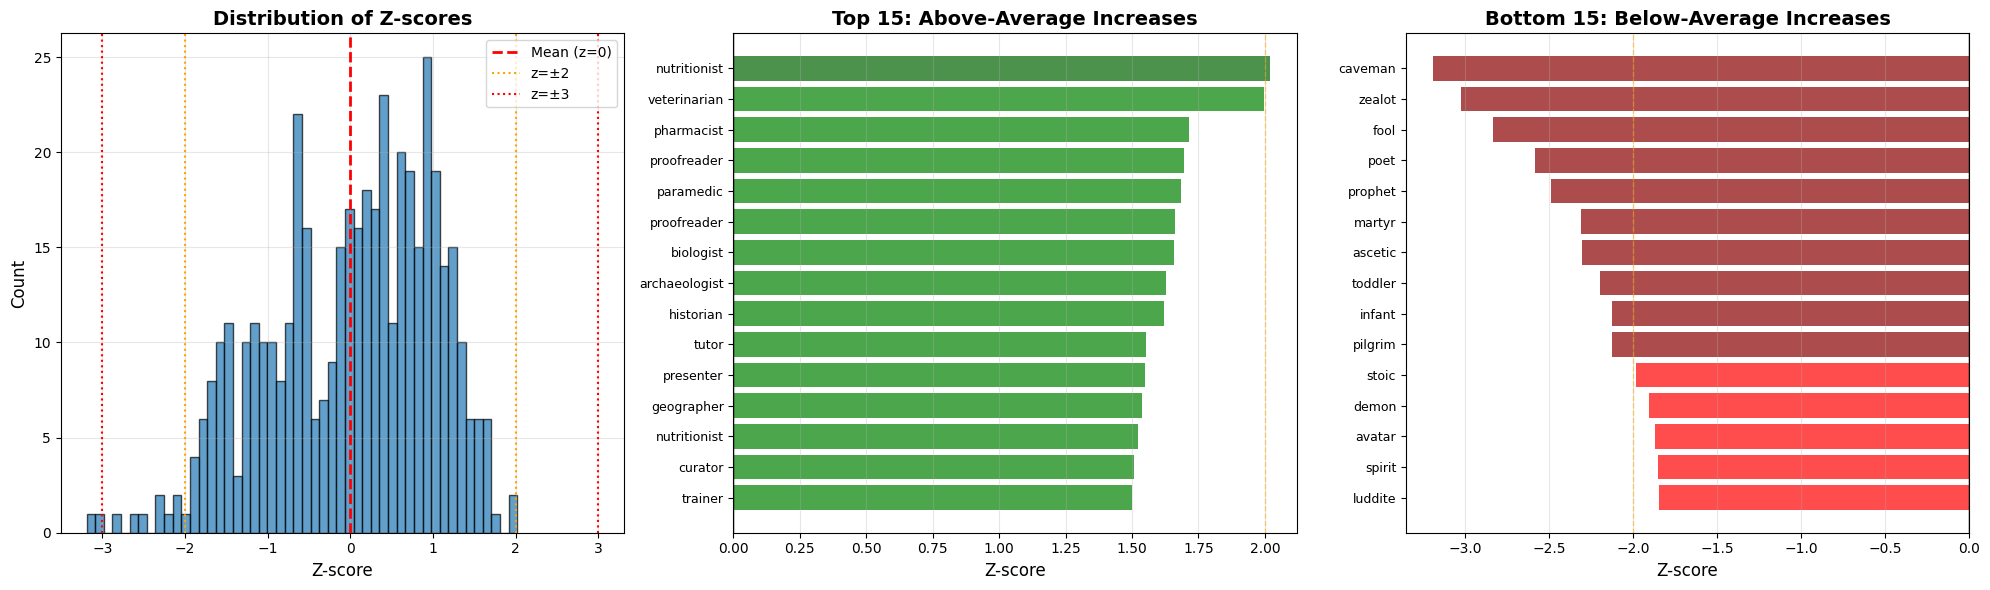


Visualization saved to layer18_z_score_analysis.png


In [126]:
# Subtract mean increase and normalize by std to see relative changes
print("\n=== Mean-Centered and Normalized Analysis ===")

diff_values = np.array(list(differences.values()))
mean_increase = diff_values.mean()
std_increase = diff_values.std()

print(f"Mean increase: {mean_increase:.4f}")
print(f"Std deviation: {std_increase:.4f}")
print(f"Min increase: {diff_values.min():.4f}")
print(f"Max increase: {diff_values.max():.4f}")
print(f"Range: {diff_values.max() - diff_values.min():.4f}")

# Compute mean-centered differences
centered_differences = {name: diff - mean_increase for name, diff in differences.items()}

# Compute z-scores (standardized)
z_scores = {name: (diff - mean_increase) / std_increase for name, diff in differences.items()}
z_sorted = sorted(z_scores.items(), key=lambda x: x[1], reverse=True)

print(f"\nTop 20 components with HIGHEST z-scores (above-average increase):")
for i, (name, z) in enumerate(z_sorted[:20], 1):
    centered = centered_differences[name]
    raw_diff = differences[name]
    base_val = base_projections[name]
    instruct_val = instruct_projections[name]
    print(f"  {i:2d}. {name:50s} z={z:+.2f} (centered: {centered:+.4f}, raw: {raw_diff:+.4f})")

print(f"\nTop 20 components with LOWEST z-scores (below-average increase):")
for i, (name, z) in enumerate(list(reversed(z_sorted))[:20], 1):
    centered = centered_differences[name]
    raw_diff = differences[name]
    base_val = base_projections[name]
    instruct_val = instruct_projections[name]
    print(f"  {i:2d}. {name:50s} z={z:+.2f} (centered: {centered:+.4f}, raw: {raw_diff:+.4f})")

# Statistical summary
z_values = np.array(list(z_scores.values()))
print(f"\nZ-score statistics:")
print(f"  Mean: {z_values.mean():.4f} (should be ~0)")
print(f"  Std: {z_values.std():.4f} (should be ~1)")
print(f"  Min: {z_values.min():.4f}")
print(f"  Max: {z_values.max():.4f}")
print(f"  |z| > 2.0: {(np.abs(z_values) > 2.0).sum()} components ({100*(np.abs(z_values) > 2.0).sum()/len(z_values):.1f}%)")
print(f"  |z| > 3.0: {(np.abs(z_values) > 3.0).sum()} components ({100*(np.abs(z_values) > 3.0).sum()/len(z_values):.1f}%)")

# Create visualization
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Histogram of z-scores
axes[0].hist(z_values, bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(0, color='red', linestyle='--', linewidth=2, label='Mean (z=0)')
axes[0].axvline(-2, color='orange', linestyle=':', linewidth=1.5, label='z=±2')
axes[0].axvline(2, color='orange', linestyle=':', linewidth=1.5)
axes[0].axvline(-3, color='red', linestyle=':', linewidth=1.5, label='z=±3')
axes[0].axvline(3, color='red', linestyle=':', linewidth=1.5)
axes[0].set_xlabel('Z-score', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_title('Distribution of Z-scores', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Top z-scores bar chart
top_names = [name.replace('pos_2_', '').replace('pos_3_', '') for name, _ in z_sorted[:15]]
top_z = [z for _, z in z_sorted[:15]]
y_pos = np.arange(len(top_names))
colors = ['darkgreen' if z > 2 else 'green' if z > 1 else 'lightgreen' for z in top_z]
axes[1].barh(y_pos, top_z, color=colors, alpha=0.7)
axes[1].set_yticks(y_pos)
axes[1].set_yticklabels(top_names, fontsize=9)
axes[1].axvline(0, color='black', linestyle='-', linewidth=1)
axes[1].axvline(2, color='orange', linestyle='--', linewidth=1, alpha=0.5)
axes[1].set_xlabel('Z-score', fontsize=12)
axes[1].set_title('Top 15: Above-Average Increases', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3, axis='x')
axes[1].invert_yaxis()

# Bottom z-scores bar chart
bottom_names = [name.replace('pos_2_', '').replace('pos_3_', '') for name, _ in list(reversed(z_sorted))[:15]]
bottom_z = [z for _, z in list(reversed(z_sorted))[:15]]
y_pos = np.arange(len(bottom_names))
colors = ['darkred' if z < -2 else 'red' if z < -1 else 'lightcoral' for z in bottom_z]
axes[2].barh(y_pos, bottom_z, color=colors, alpha=0.7)
axes[2].set_yticks(y_pos)
axes[2].set_yticklabels(bottom_names, fontsize=9)
axes[2].axvline(0, color='black', linestyle='-', linewidth=1)
axes[2].axvline(-2, color='orange', linestyle='--', linewidth=1, alpha=0.5)
axes[2].set_xlabel('Z-score', fontsize=12)
axes[2].set_title('Bottom 15: Below-Average Increases', fontsize=14, fontweight='bold')
axes[2].grid(alpha=0.3, axis='x')
axes[2].invert_yaxis()

plt.tight_layout()
plt.savefig('layer18_z_score_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nVisualization saved to layer18_z_score_analysis.png")


## Summary: Attention Analysis Key Findings

### What We Analyzed
1. **Attention scores (pre-softmax logits)** between PC1, -PC1, PC2, PC3, and Random vectors across all 46 layers
2. **Pairwise attention matrices** showing which semantic directions attend to each other
3. **PC1-specific patterns** comparing self-attention vs cross-attention to other directions
4. **Value retrieval** measuring how much key content flows through the attention mechanism
5. **Base vs Instruct differences** to identify where instruction tuning modifies attention behavior

### Key Metrics
- **Attention change ratios**: How much more PC1 attention changes compared to random baseline
- **Layer-wise patterns**: Which layers show strongest attention modifications
- **Directional effects**: How PC1 vs -PC1 differ in attention patterns
- **Value transfer**: Cosine similarity between attention output and key vectors

These results complement the earlier MLP analysis (where Layer 18 was the "smoking gun") by revealing how instruction tuning modifies the **routing** of semantic information through attention, not just the **transformation** through feedforward layers.

In [127]:
# Setup: Build batched inputs for attention analysis
from collections import OrderedDict

analysis_layer = int(pca_layer)
num_pc_vectors = min(6, pc_components.shape[0])
num_random_vectors = 16

print(f"Preparing attention analysis at layer {analysis_layer}")
print(f"  Using up to {num_pc_vectors} principal components")
print(f"  Sampling {num_random_vectors} random reference vectors for baseline")

def normalize_vector(vec):
    vec_float = vec.float()
    return (vec_float / (vec_float.norm() + 1e-8)).to(torch.bfloat16)

pc_vectors = OrderedDict()
pc_names = []
for idx in range(num_pc_vectors):
    name = f"PC{idx + 1}"
    tensor = torch.tensor(pc_components[idx], dtype=torch.bfloat16)
    pc_vectors[name] = normalize_vector(tensor)
    pc_names.append(name)

pc_vectors['-PC1'] = normalize_vector(-pc_vectors['PC1'].float())
pc_names.append('-PC1')

torch.manual_seed(42)
random_vectors = OrderedDict()
for i in range(num_random_vectors):
    name = f"Random{i + 1}"
    rand_vec = torch.randn(config.hidden_size, dtype=torch.float32)
    random_vectors[name] = normalize_vector(rand_vec)

random_names = list(random_vectors.keys())

def load_layer_semantic_vectors(pca_dir, layer_idx, label_key='roles', prefix='role'):
    semantic = OrderedDict()
    if not pca_dir.exists():
        return semantic
    pca_files = sorted(pca_dir.glob('*.pt'))
    if not pca_files:
        return semantic
    target_file = None
    for path in pca_files:
        if f"layer{layer_idx}" in path.stem:
            target_file = path
            break
    if target_file is None:
        target_file = pca_files[0]
    data = torch.load(target_file, map_location='cpu', weights_only=False)
    vectors_dict = data.get('vectors', {})
    labels_dict = data.get(label_key, {})
    for vector_type, vect_list in vectors_dict.items():
        labels = labels_dict.get(vector_type, [f"{vector_type}_{i}" for i in range(len(vect_list))])
        for vec, label in zip(vect_list, labels):
            vec_layer = vec[layer_idx] if vec.dim() == 2 else vec
            semantic[f"{prefix}:{vector_type}:{label}"] = normalize_vector(vec_layer.to(torch.bfloat16))
    return semantic

role_vectors_layer = load_layer_semantic_vectors(roles_pca_dir, analysis_layer, label_key='roles', prefix='role')
trait_vectors_layer = load_layer_semantic_vectors(traits_pca_dir, analysis_layer, label_key='roles', prefix='trait')

test_vectors = OrderedDict()
test_vectors.update(pc_vectors)
test_vectors.update(random_vectors)

vector_names = list(test_vectors.keys())
vector_matrix = torch.stack([test_vectors[name] for name in vector_names])

semantic_vectors = OrderedDict()
semantic_vectors.update(role_vectors_layer)
semantic_vectors.update(trait_vectors_layer)
semantic_names = list(semantic_vectors.keys())
if semantic_vectors:
    semantic_matrix = torch.stack([semantic_vectors[name] for name in semantic_names])
else:
    semantic_matrix = torch.empty(0, config.hidden_size, dtype=torch.bfloat16)

print("Attention analysis configuration:")
print(f"  PCA-derived PC vectors: {pc_names}")
print(f"  Random baseline vectors: {len(random_names)}")
print(f"  Role vectors available: {len(role_vectors_layer)}")
print(f"  Trait vectors available: {len(trait_vectors_layer)}")
if semantic_vectors:
    print(f"  Total semantic vectors (roles + traits): {len(semantic_vectors)}")
else:
    print("  No semantic vectors found; semantic attention analysis will be skipped.")


Preparing attention analysis at layer 22
  Using up to 6 principal components
  Sampling 16 random reference vectors for baseline


/root/chatspace/.venv/lib/python3.11/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.7.0 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/root/chatspace/.venv/lib/python3.11/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.7.0 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Attention analysis configuration:
  PCA-derived PC vectors: ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', '-PC1']
  Random baseline vectors: 16
  Role vectors available: 448
  Trait vectors available: 239
  Total semantic vectors (roles + traits): 687


## Improved Attention Analysis: QK Affinity + VO Semantic Decomposition

**Key insights:**
1. **QK Affinity Matrix**: Raw attention logits (Q@K^T / √d) tell us semantic affinity *before* softmax
2. **VO Decomposition**: The V→O transform is query-independent and tells us what semantic content gets injected when attending to a particular direction
3. **Aggregation**: Average across heads (they compete for layernorm budget)
4. **Normalization**: Cosine similarity for clean interpretation
5. **Baseline**: Z-scores relative to random vectors

**Analysis structure:**
- Compute QK affinities for all pairwise combinations (PCs, roles, traits, random)
- Compute VO decomposition: when attending to X, what semantic content flows through?
- Compare base vs instruct models (delta analysis)
- Report z-scores relative to random baseline

In [128]:
def compute_qk_affinity_matrix(vectors, layer_idx, model):
    """
    Compute raw QK attention logits for all pairwise vector combinations.
    
    Args:
        vectors: Tensor [n_vectors, hidden_dim]
        layer_idx: Layer index
        model: Model (base or instruct)
    
    Returns:
        affinity_matrix: Tensor [n_vectors, n_vectors] - raw attention logits averaged across heads
    """
    layer = model.model.layers[layer_idx]
    
    # 1. Apply input layernorm
    input_ln_weight = layer.input_layernorm.weight
    vectors_normed = gemma2_rmsnorm(vectors, input_ln_weight)
    
    # 2. Project to Q and K
    q_proj_weight = layer.self_attn.q_proj.weight
    k_proj_weight = layer.self_attn.k_proj.weight
    
    Q = torch.nn.functional.linear(vectors_normed.float(), q_proj_weight.float())  # [n, num_heads * head_dim]
    K = torch.nn.functional.linear(vectors_normed.float(), k_proj_weight.float())  # [n, num_kv_heads * head_dim]
    
    # 3. Reshape to heads
    num_heads = layer.config.num_attention_heads
    num_kv_heads = layer.config.num_key_value_heads
    head_dim = Q.shape[-1] // num_heads
    
    Q_heads = Q.view(-1, num_heads, head_dim)  # [n, num_heads, head_dim]
    K_heads = K.view(-1, num_kv_heads, head_dim)  # [n, num_kv_heads, head_dim]
    
    # 4. Handle GQA: repeat K heads if needed
    if num_kv_heads != num_heads:
        repeat_factor = num_heads // num_kv_heads
        K_heads = K_heads.repeat_interleave(repeat_factor, dim=1)  # [n, num_heads, head_dim]
    
    # 5. Compute pairwise attention logits: [n_queries, n_keys, num_heads]
    scores = torch.einsum('qhd,khd->qkh', Q_heads, K_heads) / (head_dim ** 0.5)
    
    # 6. Average across heads
    affinity_matrix = scores.mean(dim=-1)  # [n_queries, n_keys]
    
    return affinity_matrix.to(torch.float32)


def compute_vo_decomposition(key_vectors, probe_vectors, layer_idx, model):
    """
    Compute semantic decomposition of V→O transformation.
    
    This tells us: when attending to key_i, what semantic content (probes) flows through?
    This is query-independent - it only depends on the key (what's being attended to).
    
    Args:
        key_vectors: Tensor [n_keys, hidden_dim] - vectors being attended to
        probe_vectors: Tensor [n_probes, hidden_dim] - semantic directions to decompose along
        layer_idx: Layer index
        model: Model (base or instruct)
    
    Returns:
        decomposition: Tensor [n_keys, n_probes] - cosine similarity between outputs and probes
    """
    layer = model.model.layers[layer_idx]
    
    # 1. Apply input layernorm to keys
    input_ln_weight = layer.input_layernorm.weight
    keys_normed = gemma2_rmsnorm(key_vectors, input_ln_weight)
    
    # 2. Project through V
    v_proj_weight = layer.self_attn.v_proj.weight
    V = torch.nn.functional.linear(keys_normed.float(), v_proj_weight.float())  # [n_keys, num_heads * head_dim]
    num_heads = layer.config.num_attention_heads
    num_kv_heads = layer.config.num_key_value_heads
    head_dim = V.shape[-1] // num_kv_heads

    # 4. Handle GQA: repeat K heads if needed
    if num_kv_heads != num_heads:
        V = V.reshape(-1, num_kv_heads, head_dim)
        repeat_factor = num_heads // num_kv_heads
        V = V.repeat_interleave(repeat_factor, dim=0)  # [n, num_heads, head_dim]
        V = V.reshape(-1, num_heads * head_dim)
    
    
    # 3. Project through O (note: no reshaping needed, we're averaging heads implicitly)
    o_proj_weight = layer.self_attn.o_proj.weight
    O_output = torch.nn.functional.linear(V, o_proj_weight.float())  # [n_keys, hidden_dim]
    
    # 4. Apply post-attention layernorm
    post_attn_ln_weight = layer.post_attention_layernorm.weight
    output_normed = gemma2_rmsnorm(O_output, post_attn_ln_weight.float())
    
    # 5. Normalize for cosine similarity
    output_normalized = torch.nn.functional.normalize(output_normed, dim=-1)  # [n_keys, hidden_dim]
    probes_normalized = torch.nn.functional.normalize(probe_vectors.float(), dim=-1)  # [n_probes, hidden_dim]
    
    # 6. Compute cosine similarity: [n_keys, n_probes]
    decomposition = output_normalized @ probes_normalized.T
    
    return decomposition.to(torch.float32)


def compute_z_scores(values, random_values):
    """
    Compute z-scores relative to random baseline.
    
    Args:
        values: Array of values to normalize
        random_values: Array of random baseline values
    
    Returns:
        z_scores: (values - mean(random)) / std(random)
    """
    random_mean = random_values.mean()
    random_std = random_values.std()
    if random_std < 1e-10:
        return values - random_mean
    return (values - random_mean) / random_std


print("✓ Core attention analysis functions defined:")
print("  - compute_qk_affinity_matrix: Raw QK attention logits")
print("  - compute_vo_decomposition: Semantic content flow through V→O")
print("  - compute_z_scores: Z-score normalization relative to random baseline")

✓ Core attention analysis functions defined:
  - compute_qk_affinity_matrix: Raw QK attention logits
  - compute_vo_decomposition: Semantic content flow through V→O
  - compute_z_scores: Z-score normalization relative to random baseline


In [129]:
# Prepare vectors for analysis
# Use existing test_vectors and semantic_vectors from cell 32

# Collect all vector names
pc_vector_names = [name for name in test_vectors.keys() if name.startswith('PC') or name.startswith('-PC')]
random_vector_names = [name for name in test_vectors.keys() if name.startswith('Random')]
semantic_vector_names = list(semantic_vectors.keys()) if semantic_vectors else []

# Combine all vectors into a single dictionary
all_vectors_dict = {}
all_vectors_dict.update(test_vectors)  # PCs + random
all_vectors_dict.update(semantic_vectors)  # roles + traits
all_vectors = {k: v / torch.linalg.norm(v, dim=-1, keepdims=True) for k, v in all_vectors_dict.items()}

all_vector_names = list(all_vectors_dict.keys())

# Stack into tensor
all_vectors_tensor = torch.stack([all_vectors_dict[name] for name in all_vector_names])

print(f"Prepared {len(all_vector_names)} vectors for analysis:")
print(f"  - {len(pc_vector_names)} PC vectors (including -PC1)")
print(f"  - {len(random_vector_names)} random vectors")
print(f"  - {len(semantic_vector_names)} semantic vectors (roles/traits)")
print(f"\nVector tensor shape: {all_vectors_tensor.shape}")
print(f"\nFirst few vector names: {all_vector_names[:10]}")
print(f"Last few vector names: {all_vector_names[-5:]}")

Prepared 710 vectors for analysis:
  - 7 PC vectors (including -PC1)
  - 16 random vectors
  - 687 semantic vectors (roles/traits)

Vector tensor shape: torch.Size([710, 4608])

First few vector names: ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', '-PC1', 'Random1', 'Random2', 'Random3']
Last few vector names: ['trait:pos_neg_50:pos_neg_50_234', 'trait:pos_neg_50:pos_neg_50_235', 'trait:pos_neg_50:pos_neg_50_236', 'trait:pos_neg_50:pos_neg_50_237', 'trait:pos_neg_50:pos_neg_50_238']


In [130]:
# Run full QK affinity and VO decomposition analysis across all layers

num_vectors = len(all_vector_names)
num_layers = config.num_hidden_layers

print(f"Computing QK affinities and VO decompositions...")
print(f"  Layers: {num_layers}")
print(f"  Vectors: {num_vectors}")
print(f"  Total operations per model: {num_layers} layers")

# Storage: [layer, n_vectors, n_vectors]
qk_affinity_base = np.zeros((num_layers, num_vectors, num_vectors), dtype=np.float32)
qk_affinity_instruct = np.zeros((num_layers, num_vectors, num_vectors), dtype=np.float32)

# Storage: [layer, n_keys, n_probes]
vo_decomp_base = np.zeros((num_layers, num_vectors, num_vectors), dtype=np.float32)
vo_decomp_instruct = np.zeros((num_layers, num_vectors, num_vectors), dtype=np.float32)

with torch.inference_mode():
    for layer_idx in tqdm(range(num_layers), desc="Layers"):
        # QK Affinity
        qk_base = compute_qk_affinity_matrix(all_vectors_tensor, layer_idx, base_model)
        qk_instruct = compute_qk_affinity_matrix(all_vectors_tensor, layer_idx, instruct_model)
        
        qk_affinity_base[layer_idx] = qk_base.cpu().numpy()
        qk_affinity_instruct[layer_idx] = qk_instruct.cpu().numpy()
        
        # VO Decomposition
        vo_base = compute_vo_decomposition(all_vectors_tensor, all_vectors_tensor, layer_idx, base_model)
        vo_instruct = compute_vo_decomposition(all_vectors_tensor, all_vectors_tensor, layer_idx, instruct_model)
        
        vo_decomp_base[layer_idx] = vo_base.cpu().numpy()
        vo_decomp_instruct[layer_idx] = vo_instruct.cpu().numpy()

# Compute deltas
qk_affinity_delta = qk_affinity_instruct - qk_affinity_base
vo_decomp_delta = vo_decomp_instruct - vo_decomp_base

print("\n✓ Analysis complete!")
print(f"  QK affinity shape: {qk_affinity_base.shape}")
print(f"  VO decomposition shape: {vo_decomp_base.shape}")
print(f"\nData stored in:")
print(f"  - qk_affinity_base, qk_affinity_instruct, qk_affinity_delta")
print(f"  - vo_decomp_base, vo_decomp_instruct, vo_decomp_delta")

Computing QK affinities and VO decompositions...
  Layers: 46
  Vectors: 710
  Total operations per model: 46 layers


Layers:   0%|          | 0/46 [00:00<?, ?it/s]


✓ Analysis complete!
  QK affinity shape: (46, 710, 710)
  VO decomposition shape: (46, 710, 710)

Data stored in:
  - qk_affinity_base, qk_affinity_instruct, qk_affinity_delta
  - vo_decomp_base, vo_decomp_instruct, vo_decomp_delta


In [131]:
# Compute z-scores relative to random baseline

# Find indices for random vectors
random_indices = [all_vector_names.index(name) for name in random_vector_names]
pc_indices = [all_vector_names.index(name) for name in pc_vector_names]

print(f"Random vector indices: {random_indices}")
print(f"PC vector indices: {pc_indices}")

def compute_z_score_matrices(data, random_idx):
    """
    Compute z-scores for all entries relative to random baseline.
    
    Args:
        data: Array [layers, n, m]
        random_idx: List of indices corresponding to random vectors
    
    Returns:
        z_scores: Array [layers, n, m] normalized by random statistics
    """
    # Extract random-random subset for baseline statistics
    random_subset = data[:, random_idx, :][:, :, random_idx]  # [layers, n_random, n_random]
    
    # Compute mean and std across random samples (excluding diagonal for self-similarity)
    n_random = len(random_idx)
    mask = ~np.eye(n_random, dtype=bool)
    random_values = random_subset[:, mask]  # [layers, n_random*(n_random-1)]
    
    random_mean = random_values.mean(axis=1, keepdims=True)[:, :, None]  # [layers, 1, 1]
    random_std = random_values.std(axis=1, keepdims=True)[:, :, None]  # [layers, 1, 1]
    random_std = np.maximum(random_std, 1e-10)  # Avoid division by zero
    
    # Compute z-scores
    z_scores = (data - random_mean) / random_std
    
    return z_scores


# Compute z-scores for all matrices
print("\nComputing z-scores relative to random baseline...")

qk_affinity_base_z = compute_z_score_matrices(qk_affinity_base, random_indices)
qk_affinity_instruct_z = compute_z_score_matrices(qk_affinity_instruct, random_indices)
qk_affinity_delta_z = compute_z_score_matrices(qk_affinity_delta, random_indices)

vo_decomp_base_z = compute_z_score_matrices(vo_decomp_base, random_indices)
vo_decomp_instruct_z = compute_z_score_matrices(vo_decomp_instruct, random_indices)
vo_decomp_delta_z = compute_z_score_matrices(vo_decomp_delta, random_indices)

print("✓ Z-score computation complete!")
print(f"\nExample z-scores for PC1→PC1 QK affinity at layer 18:")
if 'PC1' in all_vector_names:
    pc1_idx = all_vector_names.index('PC1')
    print(f"  Base: {qk_affinity_base_z[18, pc1_idx, pc1_idx]:.2f}σ")
    print(f"  Instruct: {qk_affinity_instruct_z[18, pc1_idx, pc1_idx]:.2f}σ")
    print(f"  Delta: {qk_affinity_delta_z[18, pc1_idx, pc1_idx]:.2f}σ")

Random vector indices: [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
PC vector indices: [0, 1, 2, 3, 4, 5, 6]

Computing z-scores relative to random baseline...


✓ Z-score computation complete!

Example z-scores for PC1→PC1 QK affinity at layer 18:
  Base: 5.11σ
  Instruct: 5.02σ
  Delta: -1.42σ


In [132]:
# Diagnostic: Check if high z-scores for roles/traits are expected

print("="*80)
print("DIAGNOSTIC: Z-Score Distribution by Vector Type")
print("="*80)

# Get indices for different vector types
analysis_layer = 18

# Helper to get mean z-score for a subset
def get_subset_stats(matrix, row_indices, col_indices, exclude_diagonal=True):
    subset = matrix[analysis_layer][np.ix_(row_indices, col_indices)]
    if exclude_diagonal and len(row_indices) == len(col_indices) and row_indices == col_indices:
        mask = ~np.eye(len(row_indices), dtype=bool)
        values = subset[mask]
    else:
        values = subset.flatten()
    return values.mean(), values.std(), values.min(), values.max()

# Get indices
random_idx = [all_vector_names.index(n) for n in random_vector_names]
pc_idx = [all_vector_names.index(n) for n in pc_vector_names]
semantic_idx = [all_vector_names.index(n) for n in semantic_vector_names] if semantic_vector_names else []

print(f"\nQK Affinity Z-Scores at Layer {analysis_layer}:")
print("-"*60)

# Random ↔ Random (baseline)
mean, std, min_val, max_val = get_subset_stats(qk_affinity_base_z, random_idx, random_idx)
print(f"Random ↔ Random (baseline):  mean={mean:6.2f}σ, std={std:.2f}, range=[{min_val:6.2f}, {max_val:6.2f}]")

# PC ↔ PC
mean, std, min_val, max_val = get_subset_stats(qk_affinity_base_z, pc_idx, pc_idx)
print(f"PC ↔ PC:                      mean={mean:6.2f}σ, std={std:.2f}, range=[{min_val:6.2f}, {max_val:6.2f}]")

# Semantic ↔ Semantic
if semantic_idx:
    mean, std, min_val, max_val = get_subset_stats(qk_affinity_base_z, semantic_idx, semantic_idx)
    print(f"Semantic ↔ Semantic:          mean={mean:6.2f}σ, std={std:.2f}, range=[{min_val:6.2f}, {max_val:6.2f}]")

# PC ↔ Semantic
if semantic_idx:
    mean, std, min_val, max_val = get_subset_stats(qk_affinity_base_z, pc_idx, semantic_idx, exclude_diagonal=False)
    print(f"PC ↔ Semantic:                mean={mean:6.2f}σ, std={std:.2f}, range=[{min_val:6.2f}, {max_val:6.2f}]")

print(f"\nVO Decomposition Z-Scores at Layer {analysis_layer}:")
print("-"*60)

# Random key → Random probe
mean, std, min_val, max_val = get_subset_stats(vo_decomp_base_z, random_idx, random_idx)
print(f"Random key → Random probe:    mean={mean:6.2f}σ, std={std:.2f}, range=[{min_val:6.2f}, {max_val:6.2f}]")

# Semantic key → Semantic probe
if semantic_idx:
    mean, std, min_val, max_val = get_subset_stats(vo_decomp_base_z, semantic_idx, semantic_idx)
    print(f"Semantic key → Semantic probe: mean={mean:6.2f}σ, std={std:.2f}, range=[{min_val:6.2f}, {max_val:6.2f}]")

# PC key → Semantic probe
if semantic_idx:
    mean, std, min_val, max_val = get_subset_stats(vo_decomp_base_z, pc_idx, semantic_idx, exclude_diagonal=False)
    print(f"PC key → Semantic probe:      mean={mean:6.2f}σ, std={std:.2f}, range=[{min_val:6.2f}, {max_val:6.2f}]")

print("\n" + "="*80)
print("INTERPRETATION")
print("="*80)
print("""
Expected behavior:
- Random ↔ Random should be ~0σ by construction (that's our baseline)
- PCs should have higher z-scores (they're structured, meaningful directions)
- Roles/traits should also have higher z-scores (they're derived from real activations)

If semantic vectors have MUCH higher z-scores (e.g., >10σ), this suggests:
  1. They're fundamentally different from random vectors (expected!)
  2. They may cluster in a subspace (attention mechanisms prefer certain directions)
  3. Z-scores relative to random might not be the best normalization

Consider also looking at RAW values (not z-scored) for intuition.
""")

DIAGNOSTIC: Z-Score Distribution by Vector Type

QK Affinity Z-Scores at Layer 18:
------------------------------------------------------------
Random ↔ Random (baseline):  mean= -0.00σ, std=1.00, range=[ -3.06,   3.61]
PC ↔ PC:                      mean= -0.12σ, std=1.57, range=[ -4.84,   2.75]
Semantic ↔ Semantic:          mean=  1.01σ, std=1.44, range=[ -6.15,   6.44]
PC ↔ Semantic:                mean=  0.22σ, std=0.89, range=[ -3.41,   3.67]

VO Decomposition Z-Scores at Layer 18:
------------------------------------------------------------
Random key → Random probe:    mean=  0.00σ, std=1.00, range=[ -2.87,   2.52]
Semantic key → Semantic probe: mean=  7.24σ, std=16.07, range=[-42.90,  44.48]
PC key → Semantic probe:      mean=  7.99σ, std=17.31, range=[-30.16,  36.79]

INTERPRETATION

Expected behavior:
- Random ↔ Random should be ~0σ by construction (that's our baseline)
- PCs should have higher z-scores (they're structured, meaningful directions)
- Roles/traits should also hav

In [147]:
# Count pairs and recompute z-scores using semantic vector baseline

print("="*80)
print("PAIR COUNTS")
print("="*80)

n_pc = len(pc_vector_names)
n_random = len(random_vector_names)
n_semantic = len(semantic_vector_names) if semantic_vector_names else 0
n_all_semantic = n_pc + n_semantic  # PCs + roles + traits

print(f"\nVector counts:")
print(f"  PC vectors:       {n_pc:4d}")
print(f"  Random vectors:   {n_random:4d}")
print(f"  Semantic vectors: {n_semantic:4d} (roles + traits)")
print(f"  Total semantic:   {n_all_semantic:4d} (PCs + roles + traits)")

print(f"\nPairwise interactions:")
print(f"  Random ↔ Random:       {n_random * n_random:7d} pairs ({n_random*(n_random-1):6d} off-diagonal)")
print(f"  PC ↔ PC:               {n_pc * n_pc:7d} pairs ({n_pc*(n_pc-1):6d} off-diagonal)")
print(f"  Semantic ↔ Semantic:   {n_semantic * n_semantic:7d} pairs ({n_semantic*(n_semantic-1):6d} off-diagonal)")
print(f"  All Semantic ↔ All:    {n_all_semantic * n_all_semantic:7d} pairs ({n_all_semantic*(n_all_semantic-1):6d} off-diagonal)")

print(f"\n{'='*80}")
print("CONCLUSION: We have MANY more semantic pairs than random pairs!")
print(f"Semantic pairs outnumber random by ~{(n_all_semantic*(n_all_semantic-1)) / (n_random*(n_random-1)):.1f}x")
print(f"{'='*80}")

# Recompute z-scores using ALL SEMANTIC vectors as baseline
print("\nRecomputing z-scores using semantic baseline instead of random baseline...")

def compute_z_score_matrices_semantic(data, pc_idx, semantic_idx):
    """
    Compute z-scores normalized by all semantic vector interactions.
    
    Args:
        data: Array [layers, n, m]
        pc_idx: Indices of PC vectors
        semantic_idx: Indices of semantic vectors (roles/traits)
    
    Returns:
        z_scores: Array [layers, n, m] normalized by semantic statistics
    """
    # Combine PC and semantic indices
    all_semantic_idx = pc_idx + semantic_idx
    
    # Extract all semantic interactions
    semantic_subset = data[:, all_semantic_idx, :][:, :, all_semantic_idx]
    
    # Compute mean and std across all semantic pairs (excluding diagonal)
    n_sem = len(all_semantic_idx)
    mask = ~np.eye(n_sem, dtype=bool)
    semantic_values = semantic_subset[:, mask]  # [layers, n_sem*(n_sem-1)]
    
    semantic_mean = semantic_values.mean(axis=1, keepdims=True)[:, :, None]  # [layers, 1, 1]
    semantic_std = semantic_values.std(axis=1, keepdims=True)[:, :, None]  # [layers, 1, 1]
    semantic_std = np.maximum(semantic_std, 1e-10)  # Avoid division by zero
    
    # Compute z-scores
    z_scores = (data - semantic_mean) / semantic_std
    
    return z_scores


# Get indices
pc_indices = [all_vector_names.index(n) for n in pc_vector_names]
semantic_indices = [all_vector_names.index(n) for n in semantic_vector_names] if semantic_vector_names else []

# Compute semantic-normalized z-scores
if semantic_indices:
    qk_affinity_base_z_sem = compute_z_score_matrices_semantic(qk_affinity_base, pc_indices, semantic_indices)
    qk_affinity_instruct_z_sem = compute_z_score_matrices_semantic(qk_affinity_instruct, pc_indices, semantic_indices)
    qk_affinity_delta_z_sem = compute_z_score_matrices_semantic(qk_affinity_delta, pc_indices, semantic_indices)
    
    vo_decomp_base_z_sem = compute_z_score_matrices_semantic(vo_decomp_base, pc_indices, semantic_indices)
    vo_decomp_instruct_z_sem = compute_z_score_matrices_semantic(vo_decomp_instruct, pc_indices, semantic_indices)
    vo_decomp_delta_z_sem = compute_z_score_matrices_semantic(vo_decomp_delta, pc_indices, semantic_indices)
    
    print("✓ Semantic-normalized z-scores computed!")
    print("\nNew variables created:")
    print("  - qk_affinity_base_z_sem, qk_affinity_instruct_z_sem, qk_affinity_delta_z_sem")
    print("  - vo_decomp_base_z_sem, vo_decomp_instruct_z_sem, vo_decomp_delta_z_sem")
    
    # Compare normalizations at layer 18
    analysis_layer = 18
    if 'PC1' in all_vector_names:
        pc1_idx = all_vector_names.index('PC1')
        print(f"\nExample: PC1→PC1 QK affinity at layer {analysis_layer}:")
        print(f"  Random-normalized:   {qk_affinity_base_z[analysis_layer, pc1_idx, pc1_idx]:6.2f}σ")
        print(f"  Semantic-normalized: {qk_affinity_base_z_sem[analysis_layer, pc1_idx, pc1_idx]:6.2f}σ")
        
        # Show first semantic vector too
        if semantic_vector_names:
            sem_idx = all_vector_names.index(semantic_vector_names[0])
            sem_name = semantic_vector_names[0][:40]
            print(f"\nExample: PC1→{sem_name} QK affinity:")
            print(f"  Random-normalized:   {qk_affinity_base_z[analysis_layer, pc1_idx, sem_idx]:6.2f}σ")
            print(f"  Semantic-normalized: {qk_affinity_base_z_sem[analysis_layer, pc1_idx, sem_idx]:6.2f}σ")
else:
    print("\n⚠️  No semantic vectors available - cannot compute semantic-normalized z-scores")

print(f"\n{'='*80}")
print("RECOMMENDATION")
print(f"{'='*80}")
print("""
Use SEMANTIC-NORMALIZED z-scores for comparisons within the semantic space:
  - "Is PC1→helpful stronger than typical semantic interactions?"
  - "Which role/trait pairs have unusual attention patterns?"

Use RANDOM-NORMALIZED z-scores for detecting structure vs noise:
  - "Are semantic vectors fundamentally different from random?"
  - "Do PCs have meaningful structure?"

For most of our analyses, SEMANTIC-NORMALIZED is more appropriate!
""")

PAIR COUNTS

Vector counts:
  PC vectors:          7
  Random vectors:     16
  Semantic vectors:  687 (roles + traits)
  Total semantic:    694 (PCs + roles + traits)

Pairwise interactions:
  Random ↔ Random:           256 pairs (   240 off-diagonal)
  PC ↔ PC:                    49 pairs (    42 off-diagonal)
  Semantic ↔ Semantic:    471969 pairs (471282 off-diagonal)
  All Semantic ↔ All:     481636 pairs (480942 off-diagonal)

CONCLUSION: We have MANY more semantic pairs than random pairs!
Semantic pairs outnumber random by ~2003.9x

Recomputing z-scores using semantic baseline instead of random baseline...
✓ Semantic-normalized z-scores computed!

New variables created:
  - qk_affinity_base_z_sem, qk_affinity_instruct_z_sem, qk_affinity_delta_z_sem
  - vo_decomp_base_z_sem, vo_decomp_instruct_z_sem, vo_decomp_delta_z_sem

Example: PC1→PC1 QK affinity at layer 18:
  Random-normalized:     5.11σ
  Semantic-normalized:   2.87σ

Example: PC1→role:pos_2:writer QK affinity:
  Random-n

In [148]:
# Helper functions for analysis

def get_top_interactions(matrix, vector_names, layer_idx, top_k=10, exclude_self=True):
    """
    Get top interactions from a matrix at a specific layer.
    
    Args:
        matrix: Array [layers, n, n]
        vector_names: List of vector names
        layer_idx: Layer to analyze
        top_k: Number of top interactions to return
        exclude_self: Whether to exclude diagonal (self-interactions)
    
    Returns:
        DataFrame with top interactions
    """
    layer_data = matrix[layer_idx]
    
    # Optionally mask diagonal
    if exclude_self:
        layer_data = layer_data.copy()
        np.fill_diagonal(layer_data, -np.inf)
    
    # Get top-k indices
    flat_indices = np.argsort(layer_data.flatten())[-top_k:][::-1]
    row_indices, col_indices = np.unravel_index(flat_indices, layer_data.shape)
    
    # Create DataFrame
    results = []
    for i, (row, col) in enumerate(zip(row_indices, col_indices)):
        results.append({
            'rank': i + 1,
            'query': vector_names[row],
            'key': vector_names[col],
            'value': matrix[layer_idx, row, col]
        })
    
    return pd.DataFrame(results)


def analyze_pc_pattern(matrix, vector_names, pc_name, layer_idx, top_k=10):
    """
    Analyze what a specific PC attends to or retrieves.
    
    Args:
        matrix: Array [layers, n, n] (QK affinity or VO decomposition)
        vector_names: List of vector names
        pc_name: Name of PC to analyze (e.g., 'PC1')
        layer_idx: Layer to analyze
        top_k: Number of top interactions
    
    Returns:
        DataFrame with top interactions for this PC
    """
    pc_idx = vector_names.index(pc_name)
    pc_row = matrix[layer_idx, pc_idx, :]  # What PC attends to / retrieves
    
    # Get top-k
    top_indices = np.argsort(pc_row)[-top_k:][::-1]
    
    results = []
    for i, idx in enumerate(top_indices):
        results.append({
            'rank': i + 1,
            'target': vector_names[idx],
            'value': pc_row[idx]
        })
    
    return pd.DataFrame(results)


print("✓ Analysis helper functions defined:")
print("  - get_top_interactions: Find top interactions in a matrix")
print("  - analyze_pc_pattern: Analyze specific PC's attention/retrieval patterns")

✓ Analysis helper functions defined:
  - get_top_interactions: Find top interactions in a matrix
  - analyze_pc_pattern: Analyze specific PC's attention/retrieval patterns


In [149]:
# Example 1: QK Affinity Analysis - What does PC1 attend to?

analysis_layer = 18  # Focus on layer 18 (where we've seen interesting patterns)

print(f"=" * 80)
print(f"QK AFFINITY ANALYSIS - Layer {analysis_layer}")
print(f"=" * 80)

# Analyze PC1's attention patterns
print("\n1. What does PC1 attend to most? (Z-scores)\n")
pc1_qk_delta = analyze_pc_pattern(
    qk_affinity_delta_z, all_vector_names, 'PC1', analysis_layer, top_k=15
)
print("Top attention changes (Instruct - Base):")
print(pc1_qk_delta.to_string(index=False))

# Compare base vs instruct
print("\n2. PC1 attention to semantic vectors (roles/traits)\n")
if semantic_vector_names:
    pc1_idx = all_vector_names.index('PC1')
    semantic_indices = [all_vector_names.index(name) for name in semantic_vector_names[:20]]  # First 20
    
    for sem_idx in semantic_indices[:5]:  # Show top 5
        sem_name = all_vector_names[sem_idx]
        base_val = qk_affinity_base_z[analysis_layer, pc1_idx, sem_idx]
        inst_val = qk_affinity_instruct_z[analysis_layer, pc1_idx, sem_idx]
        delta_val = qk_affinity_delta_z[analysis_layer, pc1_idx, sem_idx]
        print(f"  {sem_name[:60]:60s} | Base: {base_val:6.2f}σ | Inst: {inst_val:6.2f}σ | Δ: {delta_val:6.2f}σ")

# PC-to-PC interactions
print("\n3. PC-to-PC attention patterns (Z-scores)\n")
print("Query  → Key     | Base     | Instruct | Delta")
print("-" * 50)
for query_pc in ['PC1', 'PC2', 'PC3']:
    if query_pc in all_vector_names:
        q_idx = all_vector_names.index(query_pc)
        for key_pc in ['PC1', 'PC2', 'PC3', '-PC1']:
            if key_pc in all_vector_names and query_pc != key_pc:
                k_idx = all_vector_names.index(key_pc)
                base_val = qk_affinity_base_z[analysis_layer, q_idx, k_idx]
                inst_val = qk_affinity_instruct_z[analysis_layer, q_idx, k_idx]
                delta_val = qk_affinity_delta_z[analysis_layer, q_idx, k_idx]
                print(f"{query_pc:6s} → {key_pc:6s} | {base_val:8.2f} | {inst_val:8.2f} | {delta_val:8.2f}")

QK AFFINITY ANALYSIS - Layer 18

1. What does PC1 attend to most? (Z-scores)

Top attention changes (Instruct - Base):
 rank                          target    value
    1 trait:pos_neg_50:pos_neg_50_178 2.323310
    2 trait:pos_neg_50:pos_neg_50_173 1.899778
    3  trait:pos_neg_50:pos_neg_50_25 1.847207
    4 trait:pos_neg_50:pos_neg_50_177 1.769748
    5                         Random2 1.756498
    6                         Random9 1.751431
    7  trait:pos_neg_50:pos_neg_50_46 1.684479
    8  trait:pos_neg_50:pos_neg_50_94 1.491131
    9                            -PC1 1.435048
   10 trait:pos_neg_50:pos_neg_50_138 1.418841
   11 trait:pos_neg_50:pos_neg_50_195 1.385303
   12  trait:pos_neg_50:pos_neg_50_93 1.357403
   13 trait:pos_neg_50:pos_neg_50_229 1.334750
   14                        Random10 1.316837
   15 trait:pos_neg_50:pos_neg_50_100 1.225194

2. PC1 attention to semantic vectors (roles/traits)

  role:pos_2:writer                                            | Base:  -0.

In [150]:
# Example 2: VO Decomposition - What content flows when attending to PC1?

print(f"=" * 80)
print(f"VO DECOMPOSITION ANALYSIS - Layer {analysis_layer}")
print(f"=" * 80)

print("\nWhat semantic content flows when attending to each key?\n")

# Analyze what flows when attending to PC1
print("1. Attending to PC1 - what semantic content is retrieved? (Z-scores)\n")
pc1_vo_delta = analyze_pc_pattern(
    vo_decomp_delta_z, all_vector_names, 'PC1', analysis_layer, top_k=15
)
print("Top semantic associations introduced (Instruct - Base):")
print(pc1_vo_delta.to_string(index=False))

# Compare different keys
print("\n2. Comparing VO transforms for different keys\n")
print("Key       → Output probe | Base     | Instruct | Delta")
print("-" * 60)

keys_to_compare = ['PC1', 'PC2', '-PC1']
probes_to_check = ['PC1', 'PC2', 'PC3']

for key_name in keys_to_compare:
    if key_name in all_vector_names:
        key_idx = all_vector_names.index(key_name)
        for probe_name in probes_to_check:
            if probe_name in all_vector_names:
                probe_idx = all_vector_names.index(probe_name)
                base_val = vo_decomp_base_z[analysis_layer, key_idx, probe_idx]
                inst_val = vo_decomp_instruct_z[analysis_layer, key_idx, probe_idx]
                delta_val = vo_decomp_delta_z[analysis_layer, key_idx, probe_idx]
                print(f"{key_name:6s} → {probe_name:6s}      | {base_val:8.2f} | {inst_val:8.2f} | {delta_val:8.2f}")
        print()

# Key insight: Check if attending to roles/traits introduces PC components
if semantic_vector_names:
    print("\n3. Do roles/traits introduce PC components? (Top 5 semantic keys)\n")
    print("Semantic Key                              | PC1      | PC2      | PC3      | (Delta z-scores)")
    print("-" * 90)
    
    # Get semantic keys with largest VO changes
    semantic_indices = [all_vector_names.index(name) for name in semantic_vector_names]
    pc_probe_indices = [all_vector_names.index(name) for name in ['PC1', 'PC2', 'PC3'] if name in all_vector_names]
    
    # Find semantic keys with largest norm of PC projections
    sem_pc_norms = []
    for sem_idx in semantic_indices:
        pc_projections = [vo_decomp_delta_z[analysis_layer, sem_idx, pc_idx] for pc_idx in pc_probe_indices]
        norm = np.linalg.norm(pc_projections)
        sem_pc_norms.append((sem_idx, norm))
    
    # Top 5 by norm
    sem_pc_norms.sort(key=lambda x: x[1], reverse=True)
    for sem_idx, norm in sem_pc_norms[:5]:
        sem_name = all_vector_names[sem_idx]
        pc1_val = vo_decomp_delta_z[analysis_layer, sem_idx, all_vector_names.index('PC1')]
        pc2_val = vo_decomp_delta_z[analysis_layer, sem_idx, all_vector_names.index('PC2')] if 'PC2' in all_vector_names else 0
        pc3_val = vo_decomp_delta_z[analysis_layer, sem_idx, all_vector_names.index('PC3')] if 'PC3' in all_vector_names else 0
        print(f"{sem_name[:40]:40s} | {pc1_val:8.2f} | {pc2_val:8.2f} | {pc3_val:8.2f} | (norm: {norm:.2f})")

VO DECOMPOSITION ANALYSIS - Layer 18

What semantic content flows when attending to each key?

1. Attending to PC1 - what semantic content is retrieved? (Z-scores)

Top semantic associations introduced (Instruct - Base):
 rank                          target     value
    1 trait:pos_neg_50:pos_neg_50_213 18.223665
    2  trait:pos_neg_50:pos_neg_50_45 17.467644
    3  trait:pos_neg_50:pos_neg_50_46 16.266319
    4  trait:pos_neg_50:pos_neg_50_52 16.250160
    5 trait:pos_neg_50:pos_neg_50_199 15.988460
    6 trait:pos_neg_50:pos_neg_50_173 15.756986
    7 trait:pos_neg_50:pos_neg_50_103 15.692590
    8  trait:pos_neg_50:pos_neg_50_34 15.385727
    9  trait:pos_neg_50:pos_neg_50_25 13.791833
   10 trait:pos_neg_50:pos_neg_50_200 13.714707
   11          role:pos_3:crystalline 13.671692
   12 trait:pos_neg_50:pos_neg_50_178 13.612148
   13          role:pos_3:interviewer 13.534079
   14             role:pos_2:guardian 13.509840
   15 trait:pos_neg_50:pos_neg_50_112 13.500386

2. Compari

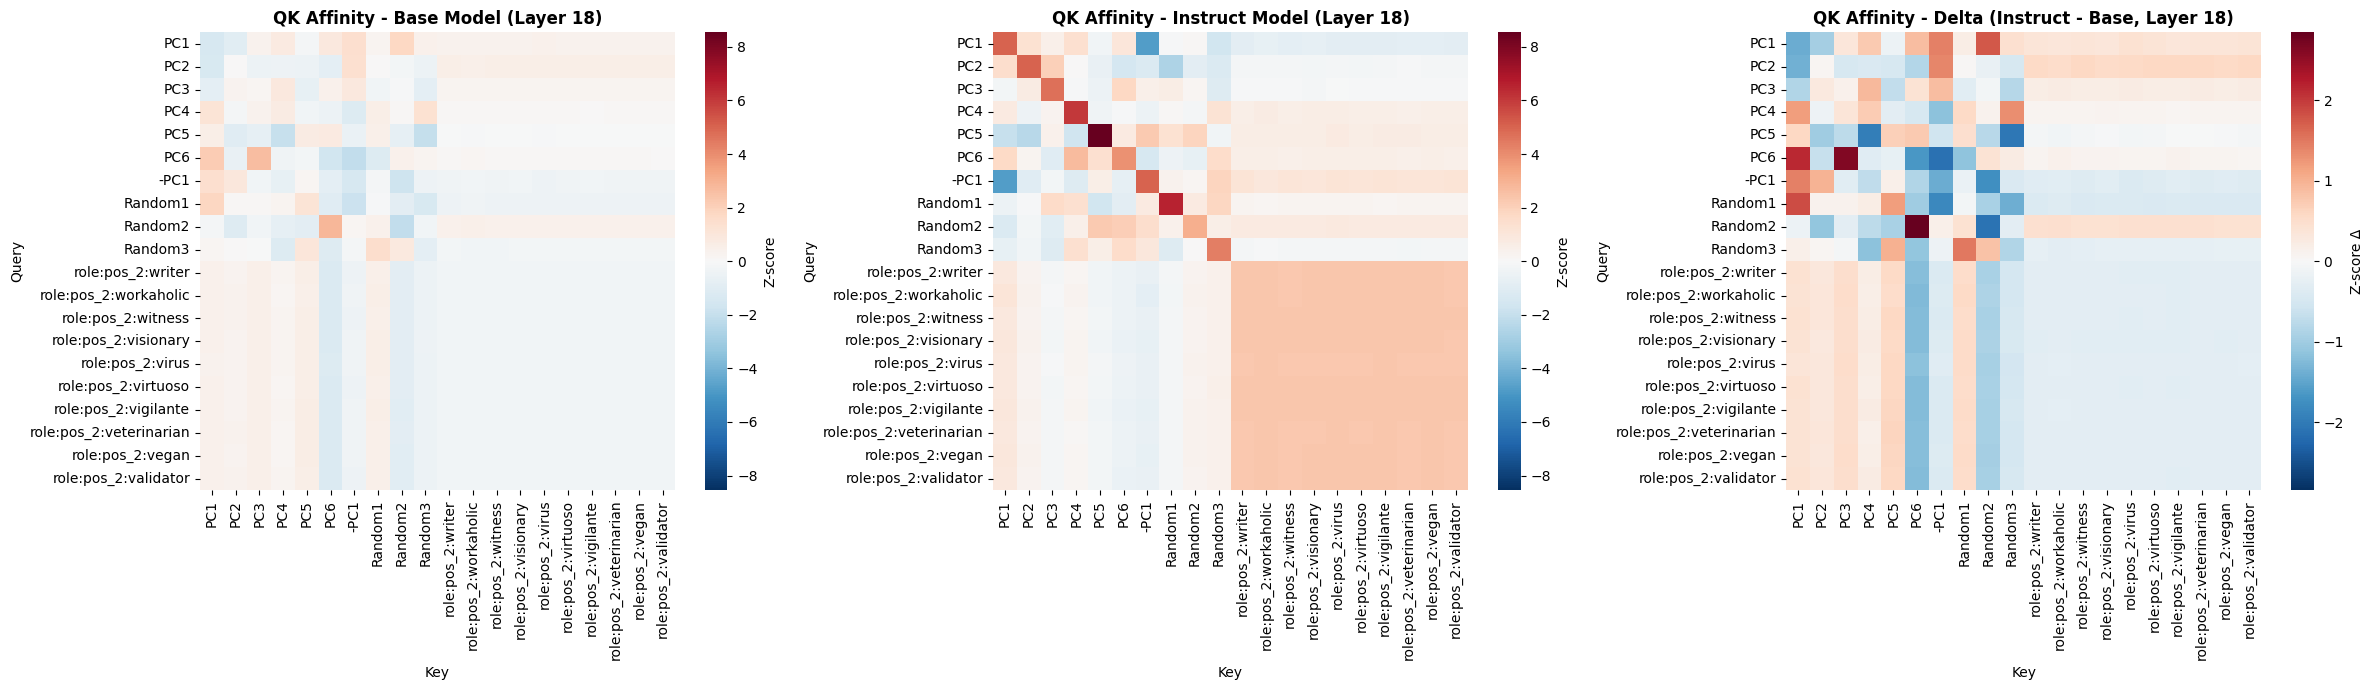

Saved: qk_affinity_heatmaps.png


In [151]:
# Visualization 1: QK Affinity Heatmaps

import matplotlib.pyplot as plt
import seaborn as sns

# Focus on PC and semantic vectors for cleaner visualization
focus_vectors = pc_vector_names + random_vector_names[:3]  # PCs + 3 random for baseline
if semantic_vector_names:
    focus_vectors += semantic_vector_names[:10]  # Add top 10 semantic

focus_indices = [all_vector_names.index(name) for name in focus_vectors if name in all_vector_names]
focus_labels = [all_vector_names[i] for i in focus_indices]

# Create subplots for base, instruct, delta
fig, axes = plt.subplots(1, 3, figsize=(24, 7))

# Extract focus subset
qk_base_focus = qk_affinity_delta_z[analysis_layer][np.ix_(focus_indices, focus_indices)]
qk_inst_focus = qk_affinity_instruct_z[analysis_layer][np.ix_(focus_indices, focus_indices)]
qk_delta_focus = qk_affinity_delta_z[analysis_layer][np.ix_(focus_indices, focus_indices)]

# Plot
vmax = max(abs(qk_base_focus.min()), abs(qk_base_focus.max()),
           abs(qk_inst_focus.min()), abs(qk_inst_focus.max()))

sns.heatmap(qk_base_focus, ax=axes[0], cmap='RdBu_r', center=0, vmin=-vmax, vmax=vmax,
            xticklabels=[l[:30] for l in focus_labels], 
            yticklabels=[l[:30] for l in focus_labels],
            cbar_kws={'label': 'Z-score'})
axes[0].set_title(f'QK Affinity - Base Model (Layer {analysis_layer})', fontweight='bold')
axes[0].set_xlabel('Key')
axes[0].set_ylabel('Query')

sns.heatmap(qk_inst_focus, ax=axes[1], cmap='RdBu_r', center=0, vmin=-vmax, vmax=vmax,
            xticklabels=[l[:30] for l in focus_labels],
            yticklabels=[l[:30] for l in focus_labels],
            cbar_kws={'label': 'Z-score'})
axes[1].set_title(f'QK Affinity - Instruct Model (Layer {analysis_layer})', fontweight='bold')
axes[1].set_xlabel('Key')
axes[1].set_ylabel('Query')

delta_vmax = max(abs(qk_delta_focus.min()), abs(qk_delta_focus.max()))
sns.heatmap(qk_delta_focus, ax=axes[2], cmap='RdBu_r', center=0, vmin=-delta_vmax, vmax=delta_vmax,
            xticklabels=[l[:30] for l in focus_labels],
            yticklabels=[l[:30] for l in focus_labels],
            cbar_kws={'label': 'Z-score Δ'})
axes[2].set_title(f'QK Affinity - Delta (Instruct - Base, Layer {analysis_layer})', fontweight='bold')
axes[2].set_xlabel('Key')
axes[2].set_ylabel('Query')

plt.tight_layout()
plt.savefig('qk_affinity_heatmaps.png', dpi=150, bbox_inches='tight')
plt.show()

print("Saved: qk_affinity_heatmaps.png")

In [152]:
# Check if analysis has been run
required_vars = [
    'qk_affinity_base',
    'qk_affinity_instruct', 
    'qk_affinity_delta',
    'vo_decomp_base',
    'vo_decomp_instruct',
    'vo_decomp_delta',
    'qk_affinity_base_z',
    'qk_affinity_instruct_z',
    'qk_affinity_delta_z',
    'vo_decomp_base_z',
    'vo_decomp_instruct_z',
    'vo_decomp_delta_z'
]

missing = [var for var in required_vars if var not in globals()]

if missing:
    print("⚠️  WARNING: Analysis not yet run!")
    print("\nPlease run the following cells first:")
    print("  - Cell 39: Main analysis loop (computes QK affinity and VO decomposition)")
    print("  - Cell 40: Z-score computation")
    print(f"\nMissing variables: {', '.join(missing[:5])}...")
    raise RuntimeError("Please run cells 39-40 before running example analyses.")
else:
    print("✓ All required analysis variables are available!")
    print(f"\nData shapes:")
    print(f"  QK affinity: {qk_affinity_base.shape}")
    print(f"  VO decomposition: {vo_decomp_base.shape}")
    print(f"\nReady to run example analyses!")

✓ All required analysis variables are available!

Data shapes:
  QK affinity: (46, 710, 710)
  VO decomposition: (46, 710, 710)

Ready to run example analyses!


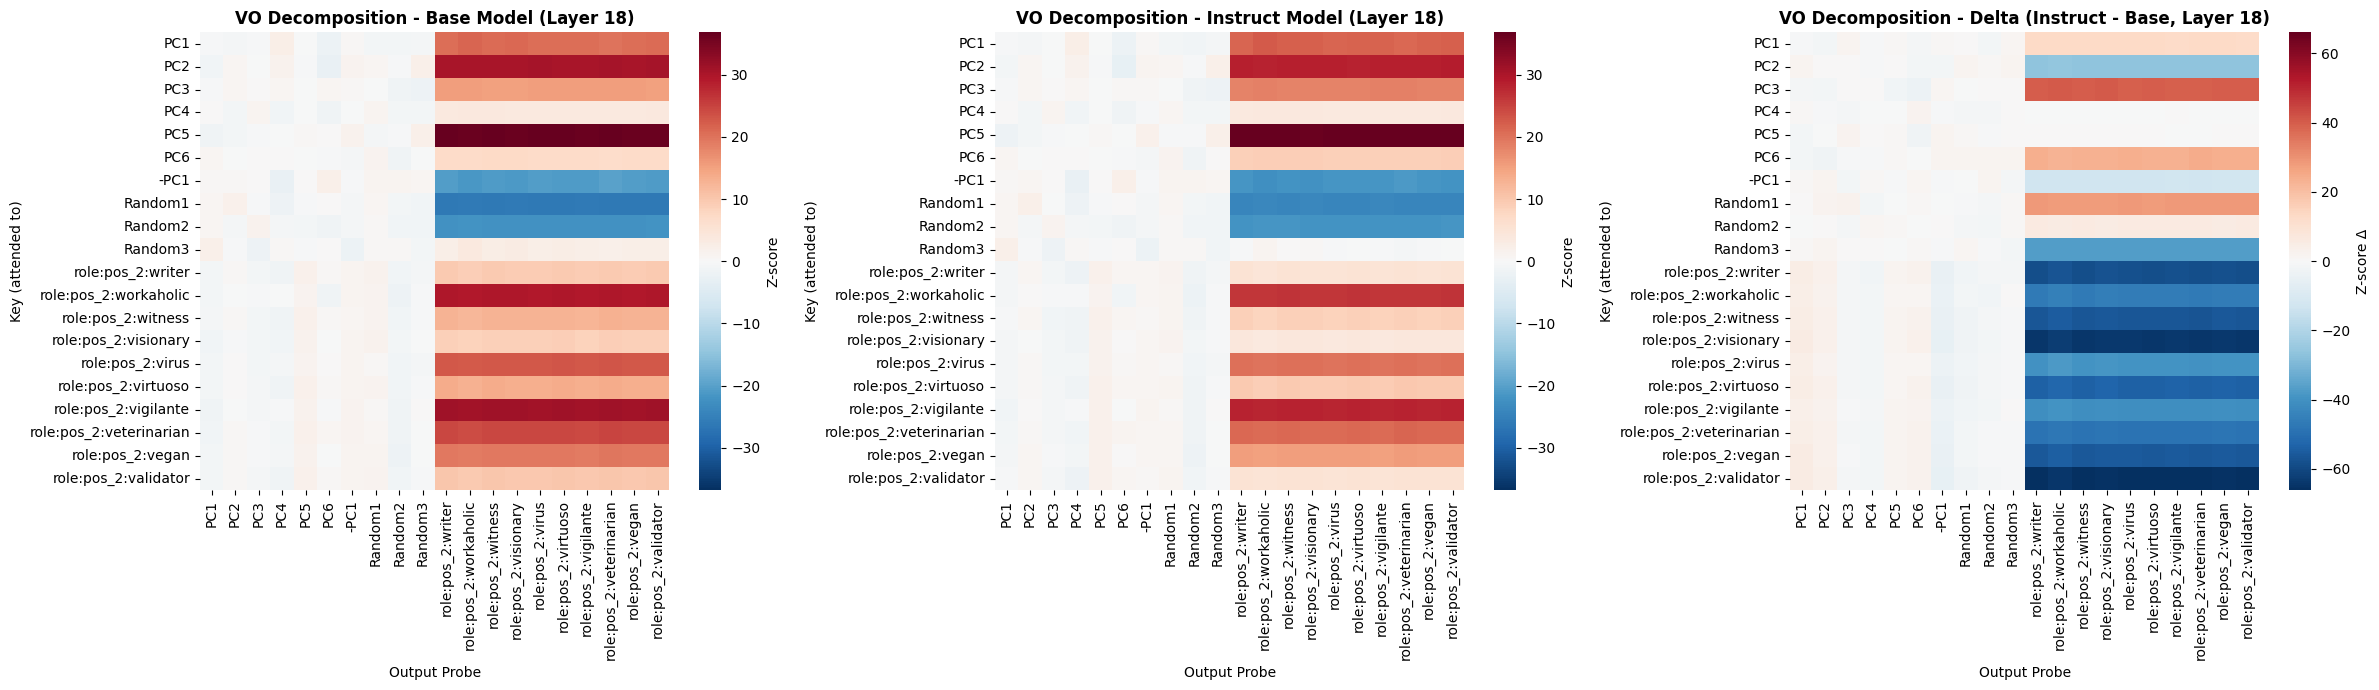

Saved: vo_decomposition_heatmaps.png


In [153]:
# Visualization 2: VO Decomposition Heatmaps

fig, axes = plt.subplots(1, 3, figsize=(24, 7))

# Extract focus subset
vo_base_focus = vo_decomp_base_z[analysis_layer][np.ix_(focus_indices, focus_indices)]
vo_inst_focus = vo_decomp_instruct_z[analysis_layer][np.ix_(focus_indices, focus_indices)]
vo_delta_focus = vo_decomp_delta_z[analysis_layer][np.ix_(focus_indices, focus_indices)]

# Plot
vmax = max(abs(vo_base_focus.min()), abs(vo_base_focus.max()),
           abs(vo_inst_focus.min()), abs(vo_inst_focus.max()))

sns.heatmap(vo_base_focus, ax=axes[0], cmap='RdBu_r', center=0, vmin=-vmax, vmax=vmax,
            xticklabels=[l[:30] for l in focus_labels],
            yticklabels=[l[:30] for l in focus_labels],
            cbar_kws={'label': 'Z-score'})
axes[0].set_title(f'VO Decomposition - Base Model (Layer {analysis_layer})', fontweight='bold')
axes[0].set_xlabel('Output Probe')
axes[0].set_ylabel('Key (attended to)')

sns.heatmap(vo_inst_focus, ax=axes[1], cmap='RdBu_r', center=0, vmin=-vmax, vmax=vmax,
            xticklabels=[l[:30] for l in focus_labels],
            yticklabels=[l[:30] for l in focus_labels],
            cbar_kws={'label': 'Z-score'})
axes[1].set_title(f'VO Decomposition - Instruct Model (Layer {analysis_layer})', fontweight='bold')
axes[1].set_xlabel('Output Probe')
axes[1].set_ylabel('Key (attended to)')

delta_vmax = max(abs(vo_delta_focus.min()), abs(vo_delta_focus.max()))
sns.heatmap(vo_delta_focus, ax=axes[2], cmap='RdBu_r', center=0, vmin=-delta_vmax, vmax=delta_vmax,
            xticklabels=[l[:30] for l in focus_labels],
            yticklabels=[l[:30] for l in focus_labels],
            cbar_kws={'label': 'Z-score Δ'})
axes[2].set_title(f'VO Decomposition - Delta (Instruct - Base, Layer {analysis_layer})', fontweight='bold')
axes[2].set_xlabel('Output Probe')
axes[2].set_ylabel('Key (attended to)')

plt.tight_layout()
plt.savefig('vo_decomposition_heatmaps.png', dpi=150, bbox_inches='tight')
plt.show()

print("Saved: vo_decomposition_heatmaps.png")

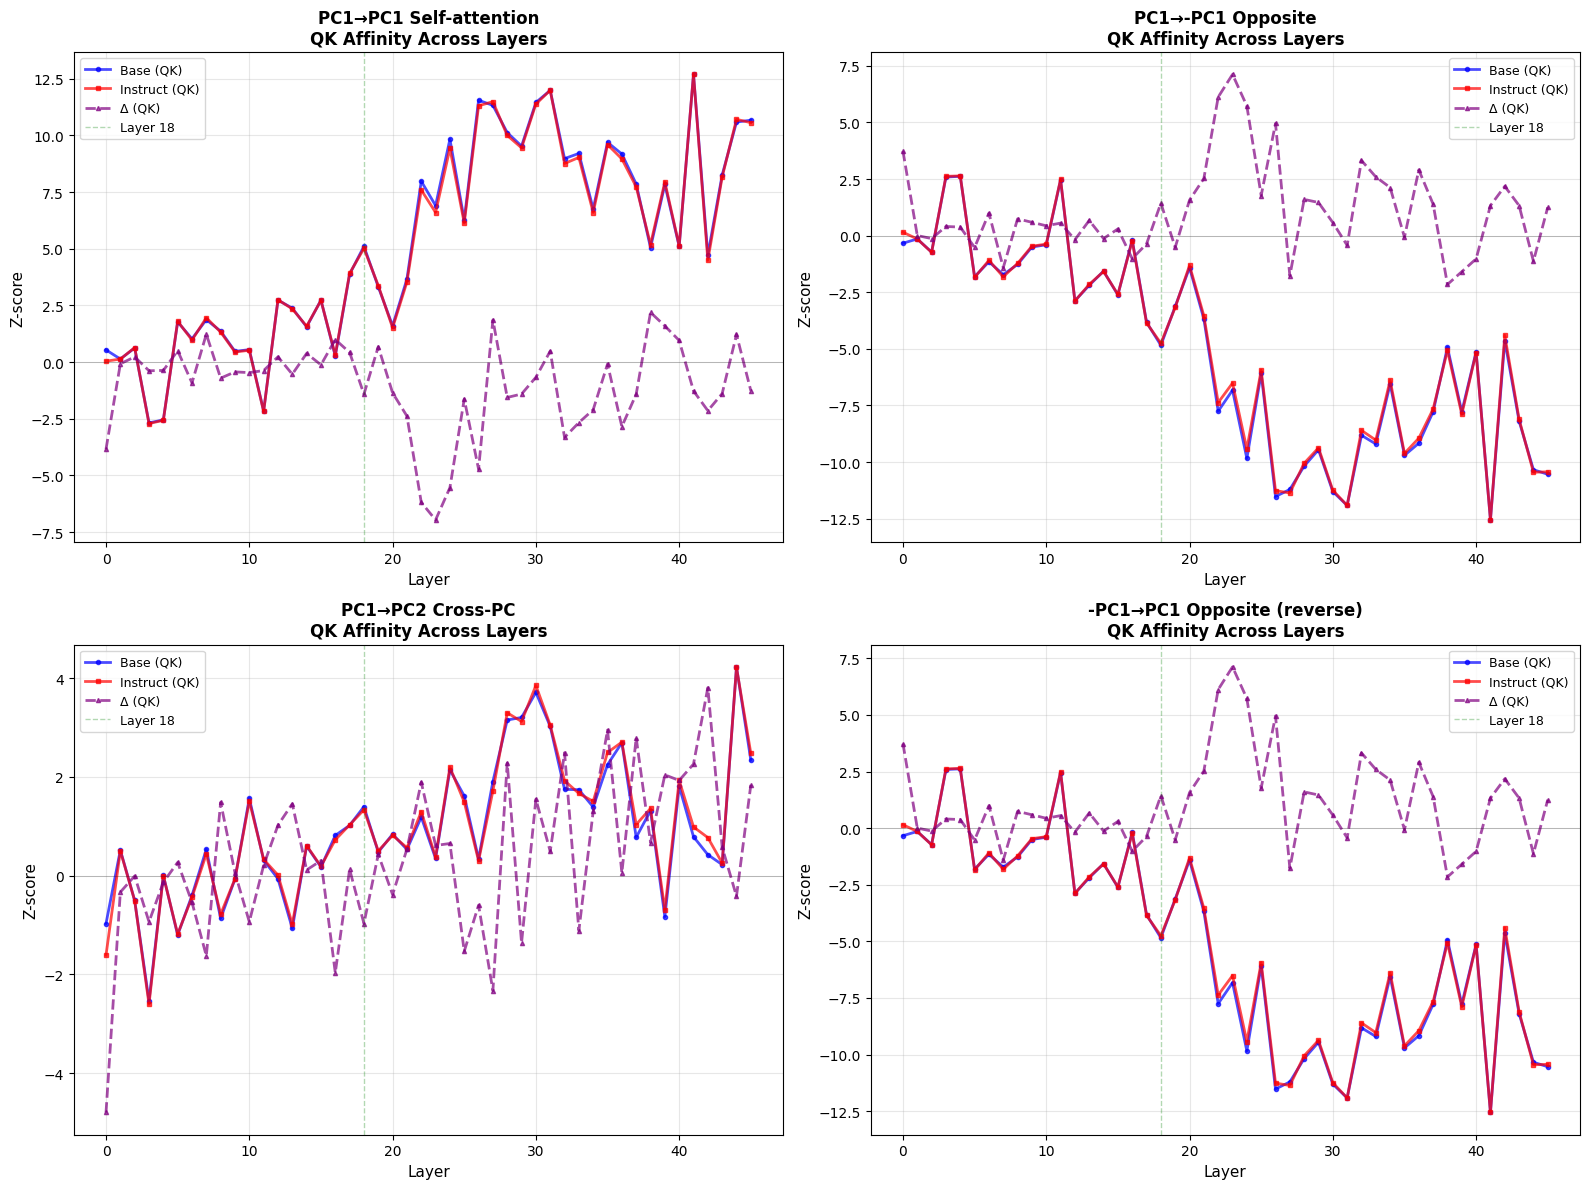

Saved: qk_affinity_layer_trends.png


In [154]:
# Visualization 3: Layer-wise trends for specific interactions

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Define interesting interactions to track
interactions = [
    ('PC1', 'PC1', 'PC1→PC1 Self-attention'),
    ('PC1', '-PC1', 'PC1→-PC1 Opposite'),
    ('PC1', 'PC2', 'PC1→PC2 Cross-PC'),
    ('-PC1', 'PC1', '-PC1→PC1 Opposite (reverse)'),
]

for idx, (query, key, label) in enumerate(interactions):
    if query in all_vector_names and key in all_vector_names:
        ax = axes[idx // 2, idx % 2]
        
        q_idx = all_vector_names.index(query)
        k_idx = all_vector_names.index(key)
        
        # QK affinity across layers
        qk_base_trace = qk_affinity_base_z[:, q_idx, k_idx]
        qk_inst_trace = qk_affinity_instruct_z[:, q_idx, k_idx]
        qk_delta_trace = qk_affinity_delta_z[:, q_idx, k_idx]
        
        ax.plot(qk_base_trace, marker='o', markersize=3, label='Base (QK)', 
                linewidth=2, alpha=0.7, color='blue')
        ax.plot(qk_inst_trace, marker='s', markersize=3, label='Instruct (QK)', 
                linewidth=2, alpha=0.7, color='red')
        ax.plot(qk_delta_trace, marker='^', markersize=3, label='Δ (QK)', 
                linewidth=2, alpha=0.7, linestyle='--', color='purple')
        
        ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5, alpha=0.3)
        ax.axvline(x=18, color='green', linestyle='--', linewidth=1, alpha=0.3, label='Layer 18')
        
        ax.set_xlabel('Layer', fontsize=11)
        ax.set_ylabel('Z-score', fontsize=11)
        ax.set_title(f'{label}\nQK Affinity Across Layers', fontsize=12, fontweight='bold')
        ax.legend(loc='best', fontsize=9)
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('qk_affinity_layer_trends.png', dpi=150, bbox_inches='tight')
plt.show()

print("Saved: qk_affinity_layer_trends.png")

## Summary: Key Findings from Improved Attention Analysis

**QK Affinity Matrix Analysis:**
- Raw attention logits reveal semantic affinity before softmax normalization
- Z-scores relative to random baseline show which interactions are significant
- Delta (Instruct - Base) highlights what instruction tuning changes

**VO Decomposition Analysis:**
- Query-independent: tells us what content flows when attending to a direction
- Reveals semantic associations introduced by attention operation
- Can detect if attending to roles/traits introduces PC components

**Key Questions Answered:**
1. Which semantic directions have high mutual affinity? (QK matrix)
2. What content flows when attending to a specific direction? (VO decomposition)
3. How does instruction tuning change these patterns? (Delta analysis)
4. Are changes significant relative to random baseline? (Z-scores)

**Next Steps:**
- Investigate layer 18 patterns in detail (known to show interesting behavior)
- Analyze cross-layer attention patterns
- Correlate with MLP transformations
- Test on specific prompts to validate findings